# This notebook aggregates all the data that was collected on the multicategory image dataset. This includes the working memory, same day and 24 hours experiments. 

## First, we aggregate all the working memroy batches together to show the final results. 
## Then we combine all the time gaps together for plotting and statistics 

In [61]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample
import statsmodels.api as sm
import os
from scipy.stats import binomtest
import scipy.stats as stats
import seaborn as sns


# Set the display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Disable wrapping to multiple lines


### Define paths 

In [62]:
project_name='multicategory_working_memory'
experiment_name='experiment 3'
qualification_method='loose' #or 'loose' or #'none' (will take the entire sample of participants that we have values for)

PATH_TO_BATCH=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'collected data' 
PATH_TO_PROJECT=path.Path.cwd().parent.parent.parent / 'projects' / project_name 
PATH_TO_EXPERIMENT=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name
PATH_TO_OUTPUTS=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'figures and outputs' 
PATH_TO_LONG_TERM_MEMORY = path.Path.cwd().parent.parent.parent / 'projects' / 'multicategory' 
if PATH_TO_BATCH.exists():
    print('batch folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('path to batch is non existent:\n',PATH_TO_BATCH)

batch folder found at:
 /Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory_working_memory/experiment 3/collected data


### This is the color pallete for the figures we use 

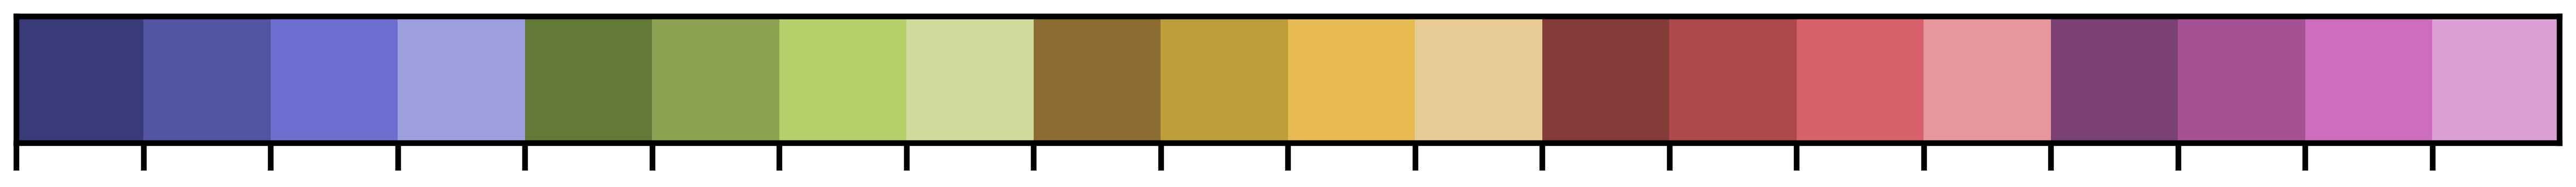

In [63]:
params = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 36,
    'axes.labelsize': 40,
    'axes.titlesize': 40,
    'xtick.labelsize': 36,
    'ytick.labelsize': 36,
    'legend.fontsize': 40,
    'lines.linewidth': 4,
    'figure.figsize': (30, 30),
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.format': 'svg',
    'savefig.bbox': 'tight'
}
plt.rcParams.update(params)

# Set Seaborn parameters
sns.set_context("poster", font_scale=1.0)
sns.set_palette('tab20b')

# Plot the color palette
sns.palplot(sns.color_palette())

# Choose a color from the palette
my_color = sns.color_palette()[2]

# Show the plot
plt.show()

### Check what is the operating system - this changes the backspace orientation 

In [64]:
import sys
import os

if sys.platform.startswith('darwin'):
    # macOS
    separator = '/'
elif sys.platform.startswith('win'):
    # Windows
    separator = '\\'
else:
    # Linux, Unix, or other
    separator = '/'
    
all_directories_paths_working_memory = [x[0] for x in os.walk(PATH_TO_BATCH) if ('batch' in x[0].split(separator)[-1]) and ('data'  not in x[0].split(separator)[-1])]
all_directories_paths_working_memory

['/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory_working_memory/experiment 3/collected data/pilot_same_day/batch 1',
 '/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory_working_memory/experiment 3/collected data/pilot_same_day/batch 3',
 '/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory_working_memory/experiment 3/collected data/pilot_same_day/batch 2']

# Working memory 

### Load all the working memory data 

In [65]:

if qualification_method=='none':
    filename = 'one_line_per_participant_all_info_all_subject_strict.csv' #note that why i do use the "strict" its irrelevant as all_subjects includes all of th em and not just qualified so criterion is irrelevant for this line
elif qualification_method in ['strict','loose']:
    filename = 'one_line_per_participant_all_info_valid_subjects_only_'+qualification_method+'.csv'
else: 
    raise Exception(f'the qualification method choosen {qualification_method} is invalid')

all_valid_subjects_working_memory = pd.DataFrame([])
for batch in all_directories_paths_working_memory:
    time_gap = 'working_memory'
    PATH_PROCESED = batch/path.Path(filename)
    file = pd.read_csv(PATH_PROCESED,index_col=0)
    file['time_gap'] = time_gap
    file['worker_ID'] = file.index 
    file['batch_number'] = int(path.Path(batch).name.split(' ')[-1])
    
    all_valid_subjects_working_memory = pd.concat([all_valid_subjects_working_memory,file])

In [66]:
print(f'there are {len(all_valid_subjects_working_memory.index) - len(set(all_valid_subjects_working_memory.index))}, duplicate subjects')

there are 0, duplicate subjects


In [67]:
def add_connecting_lines_to_stripplot(stripplot_handle,ax):
  #get the current offsets:
  paths = stripplot_handle.collections
  #get x offsets:
  x_offsets = [path.get_offsets()[:,0] for path in paths]
  x_offsets_arrays=[np.array(offsets) for offsets in x_offsets]
  #get y offsets:
  y_offsets = [path.get_offsets()[:,1] for path in paths]
  y_offsets_arrays=[np.array(offsets) for offsets in y_offsets]
  # Connect each pair of points from the same row with a line
  for bar_ind in np.arange(0,len(x_offsets_arrays)-1):
    for i in range(len(x_offsets_arrays[0])):
      ax.plot([x_offsets_arrays[bar_ind][i], x_offsets_arrays[bar_ind+1][i]], [y_offsets_arrays[bar_ind][i], y_offsets_arrays[bar_ind+1][i]], color="gray", alpha=0.65)

/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


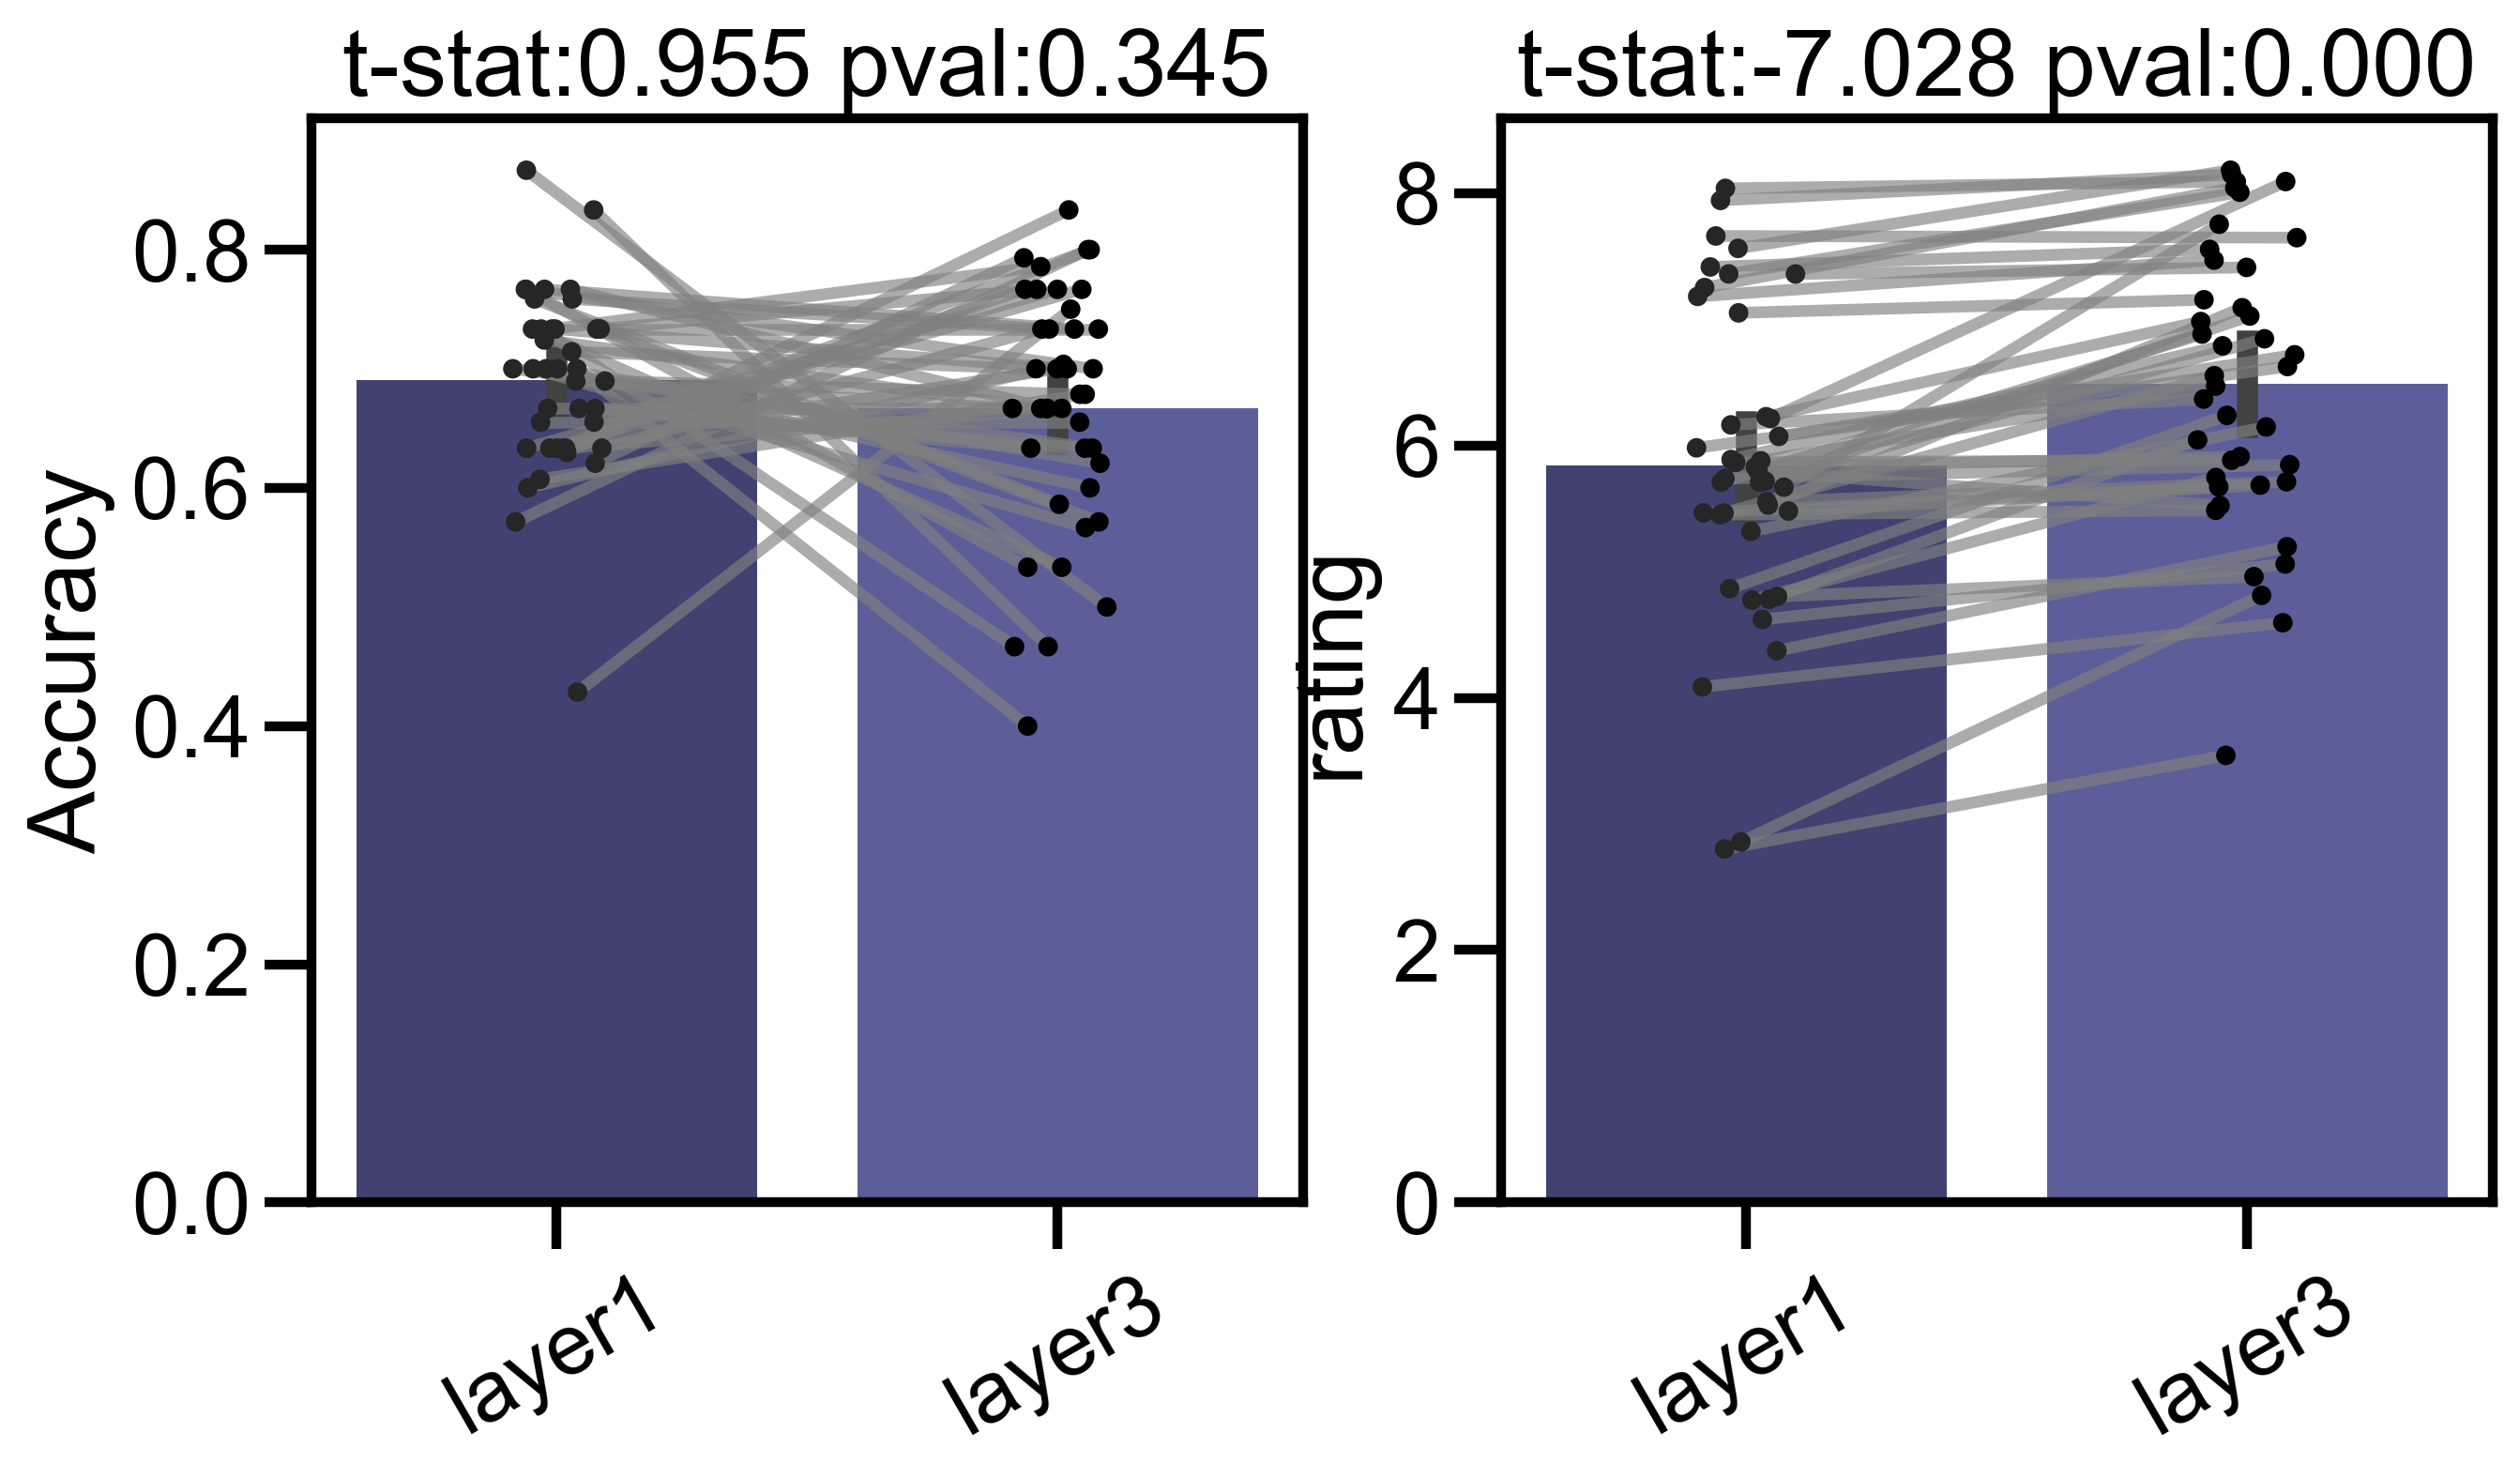

In [68]:

d1 = all_valid_subjects_working_memory['level_1_accuracy']
d2 = all_valid_subjects_working_memory['level_3_accuracy']
t_stat, p_value = stats.ttest_rel(d1, d2)


fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=all_valid_subjects_working_memory[['level_1_accuracy','level_3_accuracy']],ax=axes[0])
handel1 = sns.stripplot(data=all_valid_subjects_working_memory[['level_1_accuracy','level_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')
axes[0].set_title(f't-stat:{t_stat:.3f} pval:{p_value:.3f}')

sns.barplot(data=all_valid_subjects_working_memory[['level_1_rating','level_3_rating']],ax = axes[1])
handel2 = sns.stripplot(data=all_valid_subjects_working_memory[['level_1_rating','level_3_rating']],color='k',ax = axes[1])


d1 = all_valid_subjects_working_memory['level_1_rating']
d2 = all_valid_subjects_working_memory['level_3_rating']
t_stat, p_value = stats.ttest_rel(d1, d2)

axes[1].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[1].set_ylabel('rating')
axes[1].set_title(f't-stat:{t_stat:.3f} pval:{p_value:.3f}')


add_connecting_lines_to_stripplot(handel1,axes[0])
add_connecting_lines_to_stripplot(handel2,axes[1])

In [69]:
all_valid_subjects_working_memory['worker_ID'] = all_valid_subjects_working_memory.index
rt_df = pd.melt(all_valid_subjects_working_memory,id_vars=['worker_ID'],value_vars=['level_1_rt','level_3_rt'],var_name='layer')
accuracy_df = pd.melt(all_valid_subjects_working_memory,id_vars=['worker_ID'],value_vars=['level_1_accuracy','level_3_accuracy'],var_name='layer')

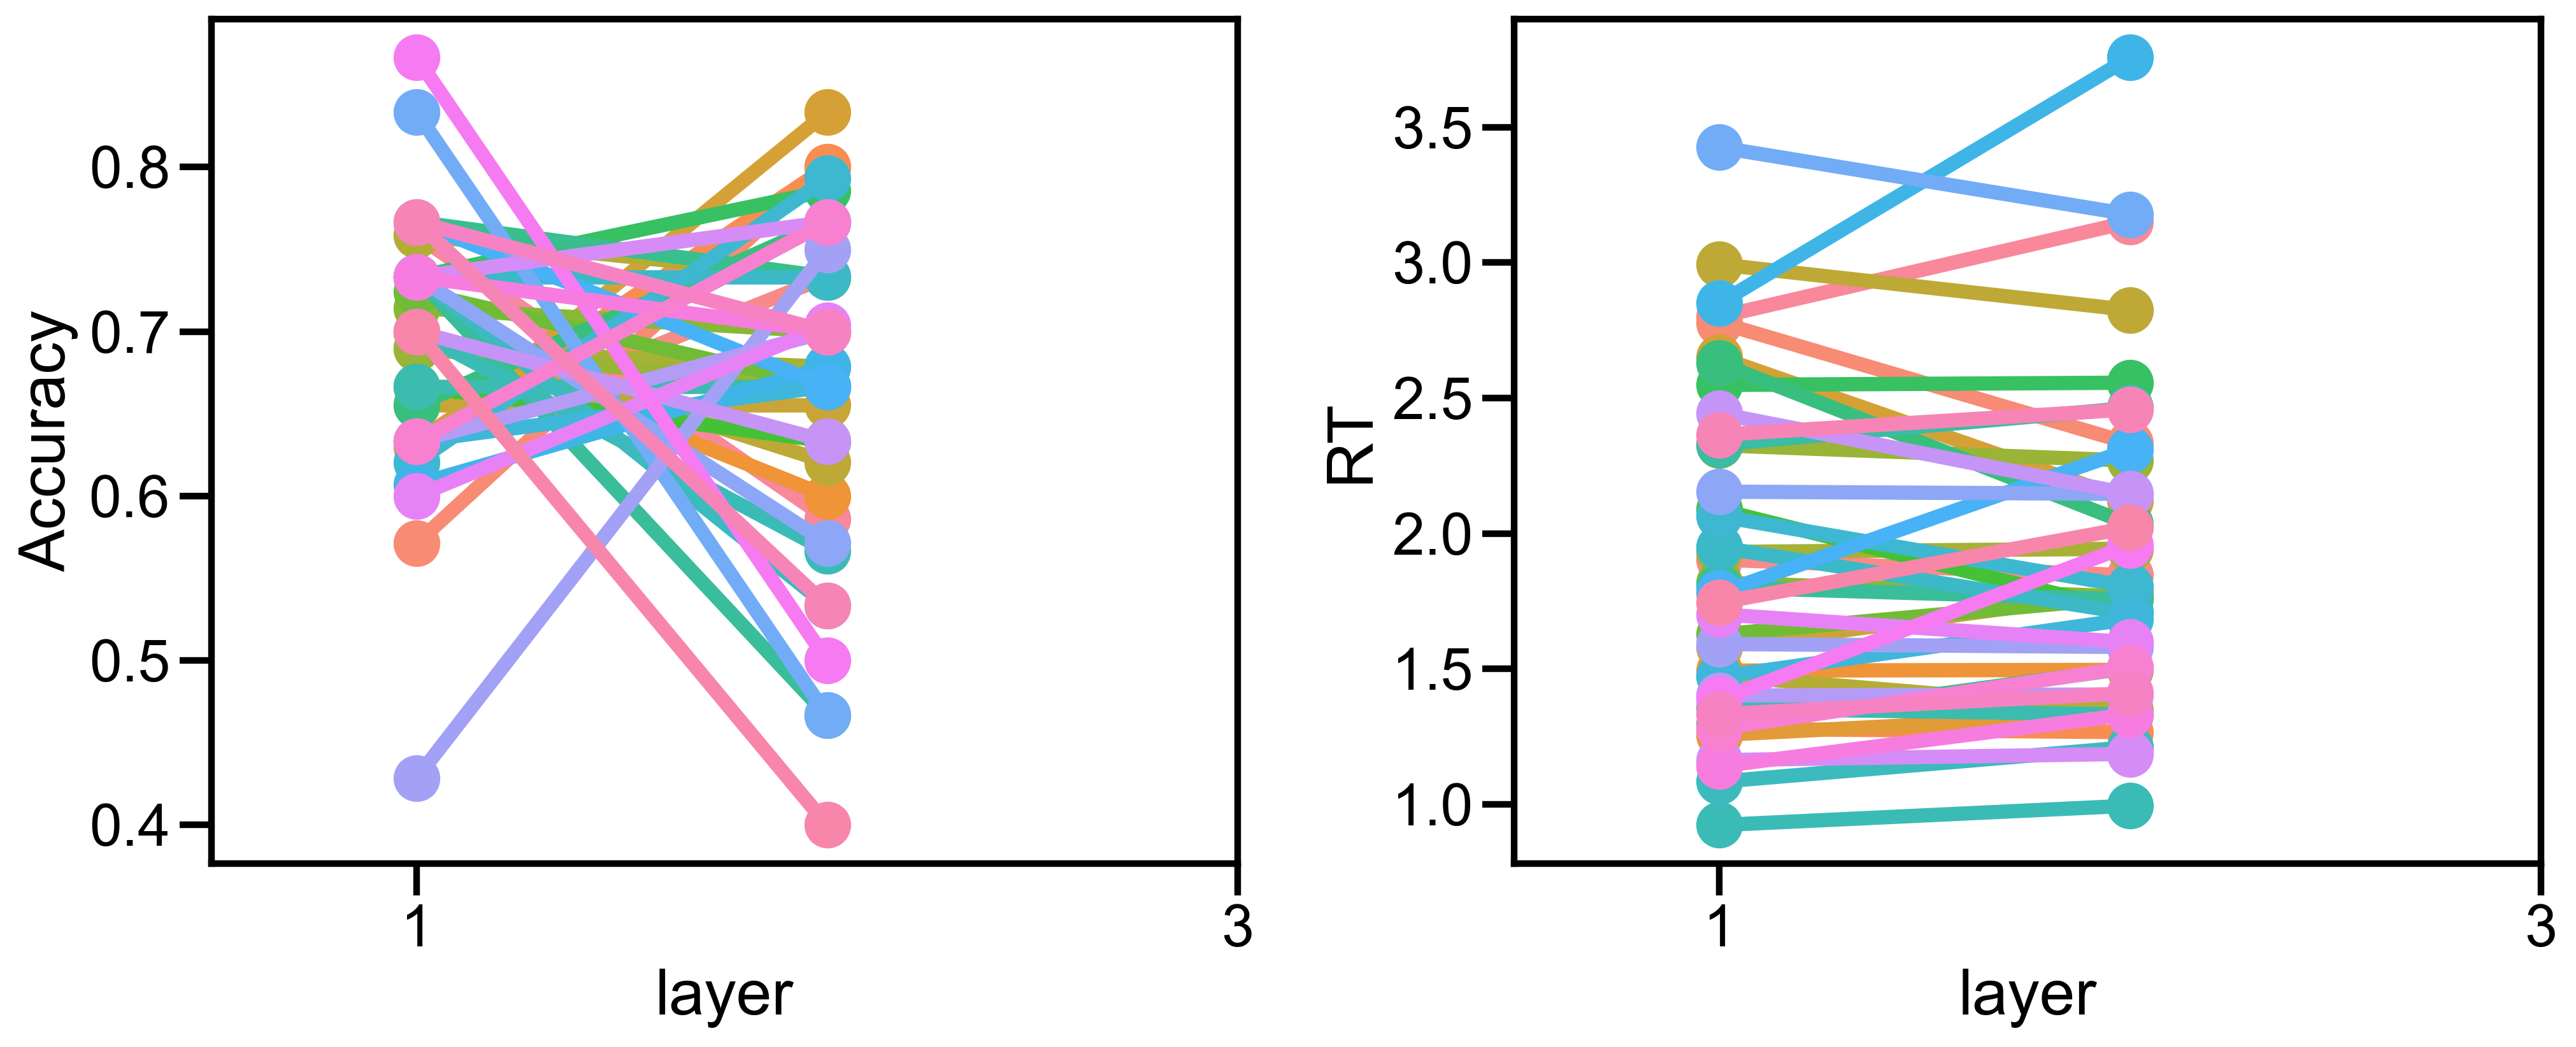

In [70]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,6),sharex=True,sharey=False)
#accuracy: 
G = sns.pointplot(data=accuracy_df,x='layer', y='value', hue='worker_ID', ax=axes[0])
plt.xticks([0,2],['1','3'])
axes[0].set_ylabel('Accuracy')
axes[0].get_legend().remove() 

#rt: 
sns.pointplot(data=rt_df,x='layer', y='value', hue='worker_ID', ax=axes[1])
plt.xticks([0,2],['1','3'])
plt.ylabel('RT')
axes[1].get_legend().remove() 
plt.tight_layout()

# All time gaps 

## concatanate the working memory data with the same day and 24 hours data

In [71]:
PATH_TO_NON_WORKING_MEMORY_TIME_GAPS =path.Path.cwd().parent.parent.parent / 'projects' / 'multicategory' / 'experiment 1' 
all_directories_paths_long_term_memory = [x[0] for x in os.walk(PATH_TO_NON_WORKING_MEMORY_TIME_GAPS) if ('batch' in x[0].split(separator)[-1]) and ('data'  not in x[0].split(separator)[-1])]
all_directories_paths_long_term_memory

['/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_same_day/batch 1',
 '/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_same_day/batch 2',
 '/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_24_hours/batch 1',
 '/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_24_hours/batch 3',
 '/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_24_hours/batch 2']

In [72]:
if qualification_method=='none':
    filename = 'one_line_per_participant_all_info_all_subject_strict.csv' #note that why i do use the "strict" its irrelevant as all_subjects includes all of th em and not just qualified so criterion is irrelevant for this line
elif qualification_method in ['strict','loose']:
    filename = 'one_line_per_participant_all_info_valid_subjects_only_'+qualification_method+'.csv'
else: 
    raise Exception(f'the qualification method choosen {qualification_method} is invalid')

all_valid_subjects_non_working_memory = pd.DataFrame([])
for batch in all_directories_paths_long_term_memory:
    time_gap = path.Path(batch).parent.name
    PATH_PROCESED = batch/path.Path(filename)
    file = pd.read_csv(PATH_PROCESED,index_col=0)
    file['time_gap'] = time_gap
    file['worker_ID'] = file.index 
    file['batch_number'] = int(path.Path(batch).name.split(' ')[-1])
    
    all_valid_subjects_non_working_memory = pd.concat([all_valid_subjects_non_working_memory,file])

In [73]:
n_24_hours= all_valid_subjects_non_working_memory['time_gap'].value_counts()['pilot_24_hours']
n_same_day= all_valid_subjects_non_working_memory['time_gap'].value_counts()['pilot_same_day']

all_valid_subjects_non_working_memory['time_gap'].value_counts()

time_gap
pilot_same_day    44
pilot_24_hours    42
Name: count, dtype: int64

## remove duplicate subjects in same day / 24 hours 

In [74]:
print(f'there are {len(all_valid_subjects_non_working_memory.index) - len(set(all_valid_subjects_non_working_memory.index))}, duplicate subjects')

there are 2, duplicate subjects


In [75]:
all_valid_subjects_non_working_memory.index.value_counts()

AEK2SAEL9GG39     2
A39KMTFHRJJASK    2
A2UWEAIX8UZXAQ    1
AW07POT8ABE05     1
AC01SVLHOB6HN     1
                 ..
A394S7JSNUA3TS    1
AZNIEFUIVB2H0     1
A1VXAJIELTYK0     1
A3CGQOJC28OVGN    1
A2J9NFY45NKR2N    1
Name: count, Length: 84, dtype: int64

In [76]:
all_valid_subjects_non_working_memory = all_valid_subjects_non_working_memory[~((all_valid_subjects_non_working_memory['worker_ID'] == 'AEK2SAEL9GG39') & (all_valid_subjects_non_working_memory['time_gap'] == 'pilot_24_hours')) ]
all_valid_subjects_non_working_memory = all_valid_subjects_non_working_memory[~((all_valid_subjects_non_working_memory['worker_ID'] == 'A39KMTFHRJJASK') & (all_valid_subjects_non_working_memory['time_gap'] == 'pilot_24_hours')) ]

In [77]:
n_24_hours= all_valid_subjects_non_working_memory['time_gap'].value_counts()['pilot_24_hours']
n_same_day= all_valid_subjects_non_working_memory['time_gap'].value_counts()['pilot_same_day']
all_valid_subjects_non_working_memory['time_gap'].value_counts()

time_gap
pilot_same_day    44
pilot_24_hours    40
Name: count, dtype: int64

## concatanate data from working memroy and previous time gaps 

In [78]:
long_term_memory_cols = {'testing_layer_1_accuracy':'level_1_accuracy',
                         'testing_layer_1_rt':'level_1_rt',
                         'testing_layer_1_rating':'level_1_rating', 

                         'testing_layer_3_accuracy':'level_3_accuracy',
                         'testing_layer_3_rt':'level_3_rt',
                         'testing_layer_3_rating':'level_3_rating', 

                         'testing_longest_response_strike':'longest_response_strike',
                         'testing_rating_mean':'rating_mean',
                         'testing_rating_varience': 'rating_varience',
                         'testing_RT_overall_mean': 'RT_overall_mean',
                         'testing_Test_overall_accuracy':'Test_overall_accuracy'


                         }

all_valid_subjects_non_working_memory.rename(columns=long_term_memory_cols,inplace=True)
all_valid_subjects_non_working_memory

demo_arrow_rt  demo_arrow_correct  demo_demo_accuracy  demo_RT_overall_mean  demo_rating_varience  demo_RT_incorrect_mean  demo_RT_correct_mean  encoding_arrow_mean_rt  encoding_arrow_accuracy  Test_overall_accuracy  RT_overall_mean  rating_varience  rating_mean  level_1_rating  level_3_rating  testing_RT_incorrect_mean  testing_RT_correct_mean  level_1_rt  level_1_accuracy  level_3_rt  level_3_accuracy  longest_response_strike        time_gap       worker_ID  batch_number
A17K1CHOI773VZ         1.3138                 1.0            0.666667              3.189917              1.834848                2.376300              3.596725                 1.34020                      1.0               0.733333         5.368782         2.045803     4.466667        4.033333        4.900000                   7.745687                 4.504452    4.506480          0.833333    6.231083          0.633333                      4.0  pilot_same_day  A17K1CHOI773VZ             1
AMHUDJ44HF1ZH          0.7300                 1.0            0.500000              2.712833              4.381780                2.982133              2.443533                 0.69402                      1.0               0.816667         2.433175         1.806767     6.700000        6.033333        7.366667                   2.643782                 2.385896    2.360230          0.733333    2.506120          0.900000                      4.0  pilot_same_day   AMHUDJ44HF1ZH             1
AGOBQY50VQ7VX          1.1111                 1.0            0.500000              3.341400              0.516398                1.598633              5.084167                 1.04190                      1.0               0.816667         2.228652         1.676019     6.733333        6.733333        6.733333                   2.623264                 2.140065    2.084323          0.833333    2.372980          0.800000                      6.0  pilot_same_day   AGOBQY50VQ7VX             1
A23J0G72AUTS1I         1.3290                 1.0            0.333333             12.004650              2.338090               16.544175              2.925600                 1.05904                      1.0               0.783333         2.873752         1.619444     6.433333        6.666667        6.200000                   2.319831                 3.026964    2.111473          0.900000    3.636030          0.666667                      3.0  pilot_same_day  A23J0G72AUTS1I             1
ATPW1MWLW7RBL          1.0961                 1.0            1.000000              2.207467              1.471960                     NaN              2.207467                 1.20210                      1.0               0.800000         1.833232         1.904500     6.000000        5.966667        6.033333                   1.952917                 1.803310    1.759800          0.833333    1.906663          0.766667                      9.0  pilot_same_day   ATPW1MWLW7RBL             1
...                       ...                 ...                 ...                   ...                   ...                     ...                   ...                     ...                      ...                    ...              ...              ...          ...             ...             ...                        ...                      ...         ...               ...         ...               ...                      ...             ...             ...           ...
A2F48NO7AD9VKK         0.6011                 1.0            0.333333              3.500517              0.408248                4.163150              2.175250                 0.54320                      1.0               0.716667         3.422595         1.511818     3.550000        3.366667        3.733333                   3.469447                 3.404072    3.646127          0.633333    3.199063          0.800000                      5.0  pilot_24_hours  A2F48NO7AD9VKK             2
A19AYB3M3IIP51         1.7267                 1.0            0.5

In [79]:
all_subjects_working_memory_and_time_gaps = pd.concat([all_valid_subjects_non_working_memory,all_valid_subjects_working_memory])

# remove duplicate values working memory - long term memory 

In [80]:
all_subjects_working_memory_and_time_gaps['worker_ID'].value_counts()

worker_ID
A8C3WNWRBWUXO     2
A1969Q0R4Y0E3J    2
A2VO8C41JJIQY9    2
A10HW8JXM17XLD    1
A3DLP5ADP74EI0    1
                 ..
A2INGGZW5GH6RM    1
A2VR9O234UCT9T    1
A28HB7240OFGEW    1
A2GE831IS8US6K    1
A1ZFUHVIPQOVGK    1
Name: count, Length: 122, dtype: int64

In [81]:
all_subjects_working_memory_and_time_gaps = all_subjects_working_memory_and_time_gaps[~((all_subjects_working_memory_and_time_gaps['worker_ID'] == 'A8C3WNWRBWUXO') & (all_subjects_working_memory_and_time_gaps['time_gap'] == 'working_memory')) ]
all_subjects_working_memory_and_time_gaps = all_subjects_working_memory_and_time_gaps[~((all_subjects_working_memory_and_time_gaps['worker_ID'] == 'A1969Q0R4Y0E3J') & (all_subjects_working_memory_and_time_gaps['time_gap'] == 'working_memory')) ]
all_subjects_working_memory_and_time_gaps = all_subjects_working_memory_and_time_gaps[~((all_subjects_working_memory_and_time_gaps['worker_ID'] == 'A2VO8C41JJIQY9') & (all_subjects_working_memory_and_time_gaps['time_gap'] == 'working_memory')) ]

# renaming columns to concatenate all time gaps 

In [82]:
renameing_dict = {'level_1_rating':'low_level_rating',
            'level_3_rating':'high_level_rating',
            'level_1_accuracy':'low_level_accuracy',
            'level_3_accuracy':'high_level_accuracy',
            'level_1_rt':'low_level_rt',
            'level_3_rt':'high_level_rt',
            'testing_RT_correct_mean':'RT_correct_mean',
            'testing_RT_incorrect_mean':'RT_incorrect_mean',
            'Test_overall_accuracy' : 'overall_accuracy'
}
all_subjects_working_memory_and_time_gaps.rename(columns=renameing_dict,inplace=True)

In [83]:
all_subjects_working_memory_and_time_gaps.to_csv(PATH_TO_EXPERIMENT / ('all_data_working_memory_and_long_term_'+qualification_method+' .csv'),index=False,)

## This section adds a new disqualification methods if flagged. 
## We check the following three options: 
1. outliers in accuracy above 2 std from mean per time gap 
2. outliers in delta (difference between accuracy in layer 1 vs layer 3) above 2 std from mean per time gap 
3. removing subjects with accuracy bellow 0.5 in one of the conditions 

In [84]:
remove_outliers = False

# thresholds: 
delta_z_th = 2
z_th = 2
acc_th = 0.5

delta_name = 'include_delta_z_th'
z_score_name = 'include_z_th'
accuracy_name = 'include_acc_th'

# place your qualification method here:
selected_method = delta_name

In [85]:
all_subjects_working_memory_and_time_gaps['delta'] = all_subjects_working_memory_and_time_gaps['high_level_accuracy'] - all_subjects_working_memory_and_time_gaps['low_level_accuracy']
all_subjects_working_memory_and_time_gaps['binary_delta'] = all_subjects_working_memory_and_time_gaps['delta'] >= 0

In [86]:
timegaps_df_list=[]
for timegap in all_subjects_working_memory_and_time_gaps['time_gap'].unique():
    measures_df_list=[]
    for curcol in [['low_level_accuracy','high_level_accuracy','delta']]:
        cur_df = all_subjects_working_memory_and_time_gaps[all_subjects_working_memory_and_time_gaps['time_gap'] == timegap][curcol]
        cur_zdf=(cur_df - cur_df.mean())/cur_df.std()
        measures_df_list.append(cur_zdf)
    zmeasures_df_timegap=pd.concat(measures_df_list)
    zmeasures_df_timegap['timegap']=timegap
    timegaps_df_list.append(zmeasures_df_timegap)
all_timegaps_df_zscores=pd.concat(timegaps_df_list,axis=0)
display(all_timegaps_df_zscores)

low_level_accuracy  high_level_accuracy     delta         timegap
A17K1CHOI773VZ            0.366801            -0.659594 -1.065322  pilot_same_day
AMHUDJ44HF1ZH            -0.701779             1.144569  1.897988  pilot_same_day
AGOBQY50VQ7VX             0.366801             0.468008  0.281637  pilot_same_day
A23J0G72AUTS1I            1.079188            -0.434074 -1.334714  pilot_same_day
ATPW1MWLW7RBL             0.366801             0.242487  0.012245  pilot_same_day
...                            ...                  ...       ...             ...
A3VWJQ8RNAPEO4           -1.156012             0.295925  0.766428  working_memory
A10JXOU89D5RXR           -0.694013             0.929463  0.967719  working_memory
ALYR5CI2SM2JC             1.153983             0.258658 -0.390997  working_memory
A1SUXLAA9QS64Y            1.153983            -1.418354 -1.523260  working_memory
A1ZFUHVIPQOVGK            0.229985            -2.759964 -1.976165  working_memory

[122 rows x 4 columns]

In [87]:
all_subjects_working_memory_and_time_gaps = all_subjects_working_memory_and_time_gaps.join(all_timegaps_df_zscores,rsuffix='_z')

In [88]:
# we calulate the z score seperatly for each time gap !
all_subjects_working_memory_and_time_gaps['include_delta_z_th'] = all_subjects_working_memory_and_time_gaps['delta_z'].abs()<=delta_z_th
all_subjects_working_memory_and_time_gaps['include_z_th'] = (all_subjects_working_memory_and_time_gaps['low_level_accuracy_z'].abs()<= z_th) & (all_subjects_working_memory_and_time_gaps['high_level_accuracy_z'].abs()<= z_th)
all_subjects_working_memory_and_time_gaps['include_acc_th'] = (all_subjects_working_memory_and_time_gaps['low_level_accuracy']>= acc_th) & (all_subjects_working_memory_and_time_gaps['high_level_accuracy']>= acc_th)

In [89]:
if remove_outliers:
    all_subjects_working_memory_and_time_gaps = all_subjects_working_memory_and_time_gaps[all_subjects_working_memory_and_time_gaps[selected_method]]

In [90]:
n_24_hours= all_subjects_working_memory_and_time_gaps['time_gap'].value_counts()['pilot_24_hours']
n_same_day= all_subjects_working_memory_and_time_gaps['time_gap'].value_counts()['pilot_same_day']
n_working_memory= all_subjects_working_memory_and_time_gaps['time_gap'].value_counts()['working_memory']


all_subjects_working_memory_and_time_gaps['time_gap'].value_counts()

time_gap
pilot_same_day    44
pilot_24_hours    40
working_memory    38
Name: count, dtype: int64

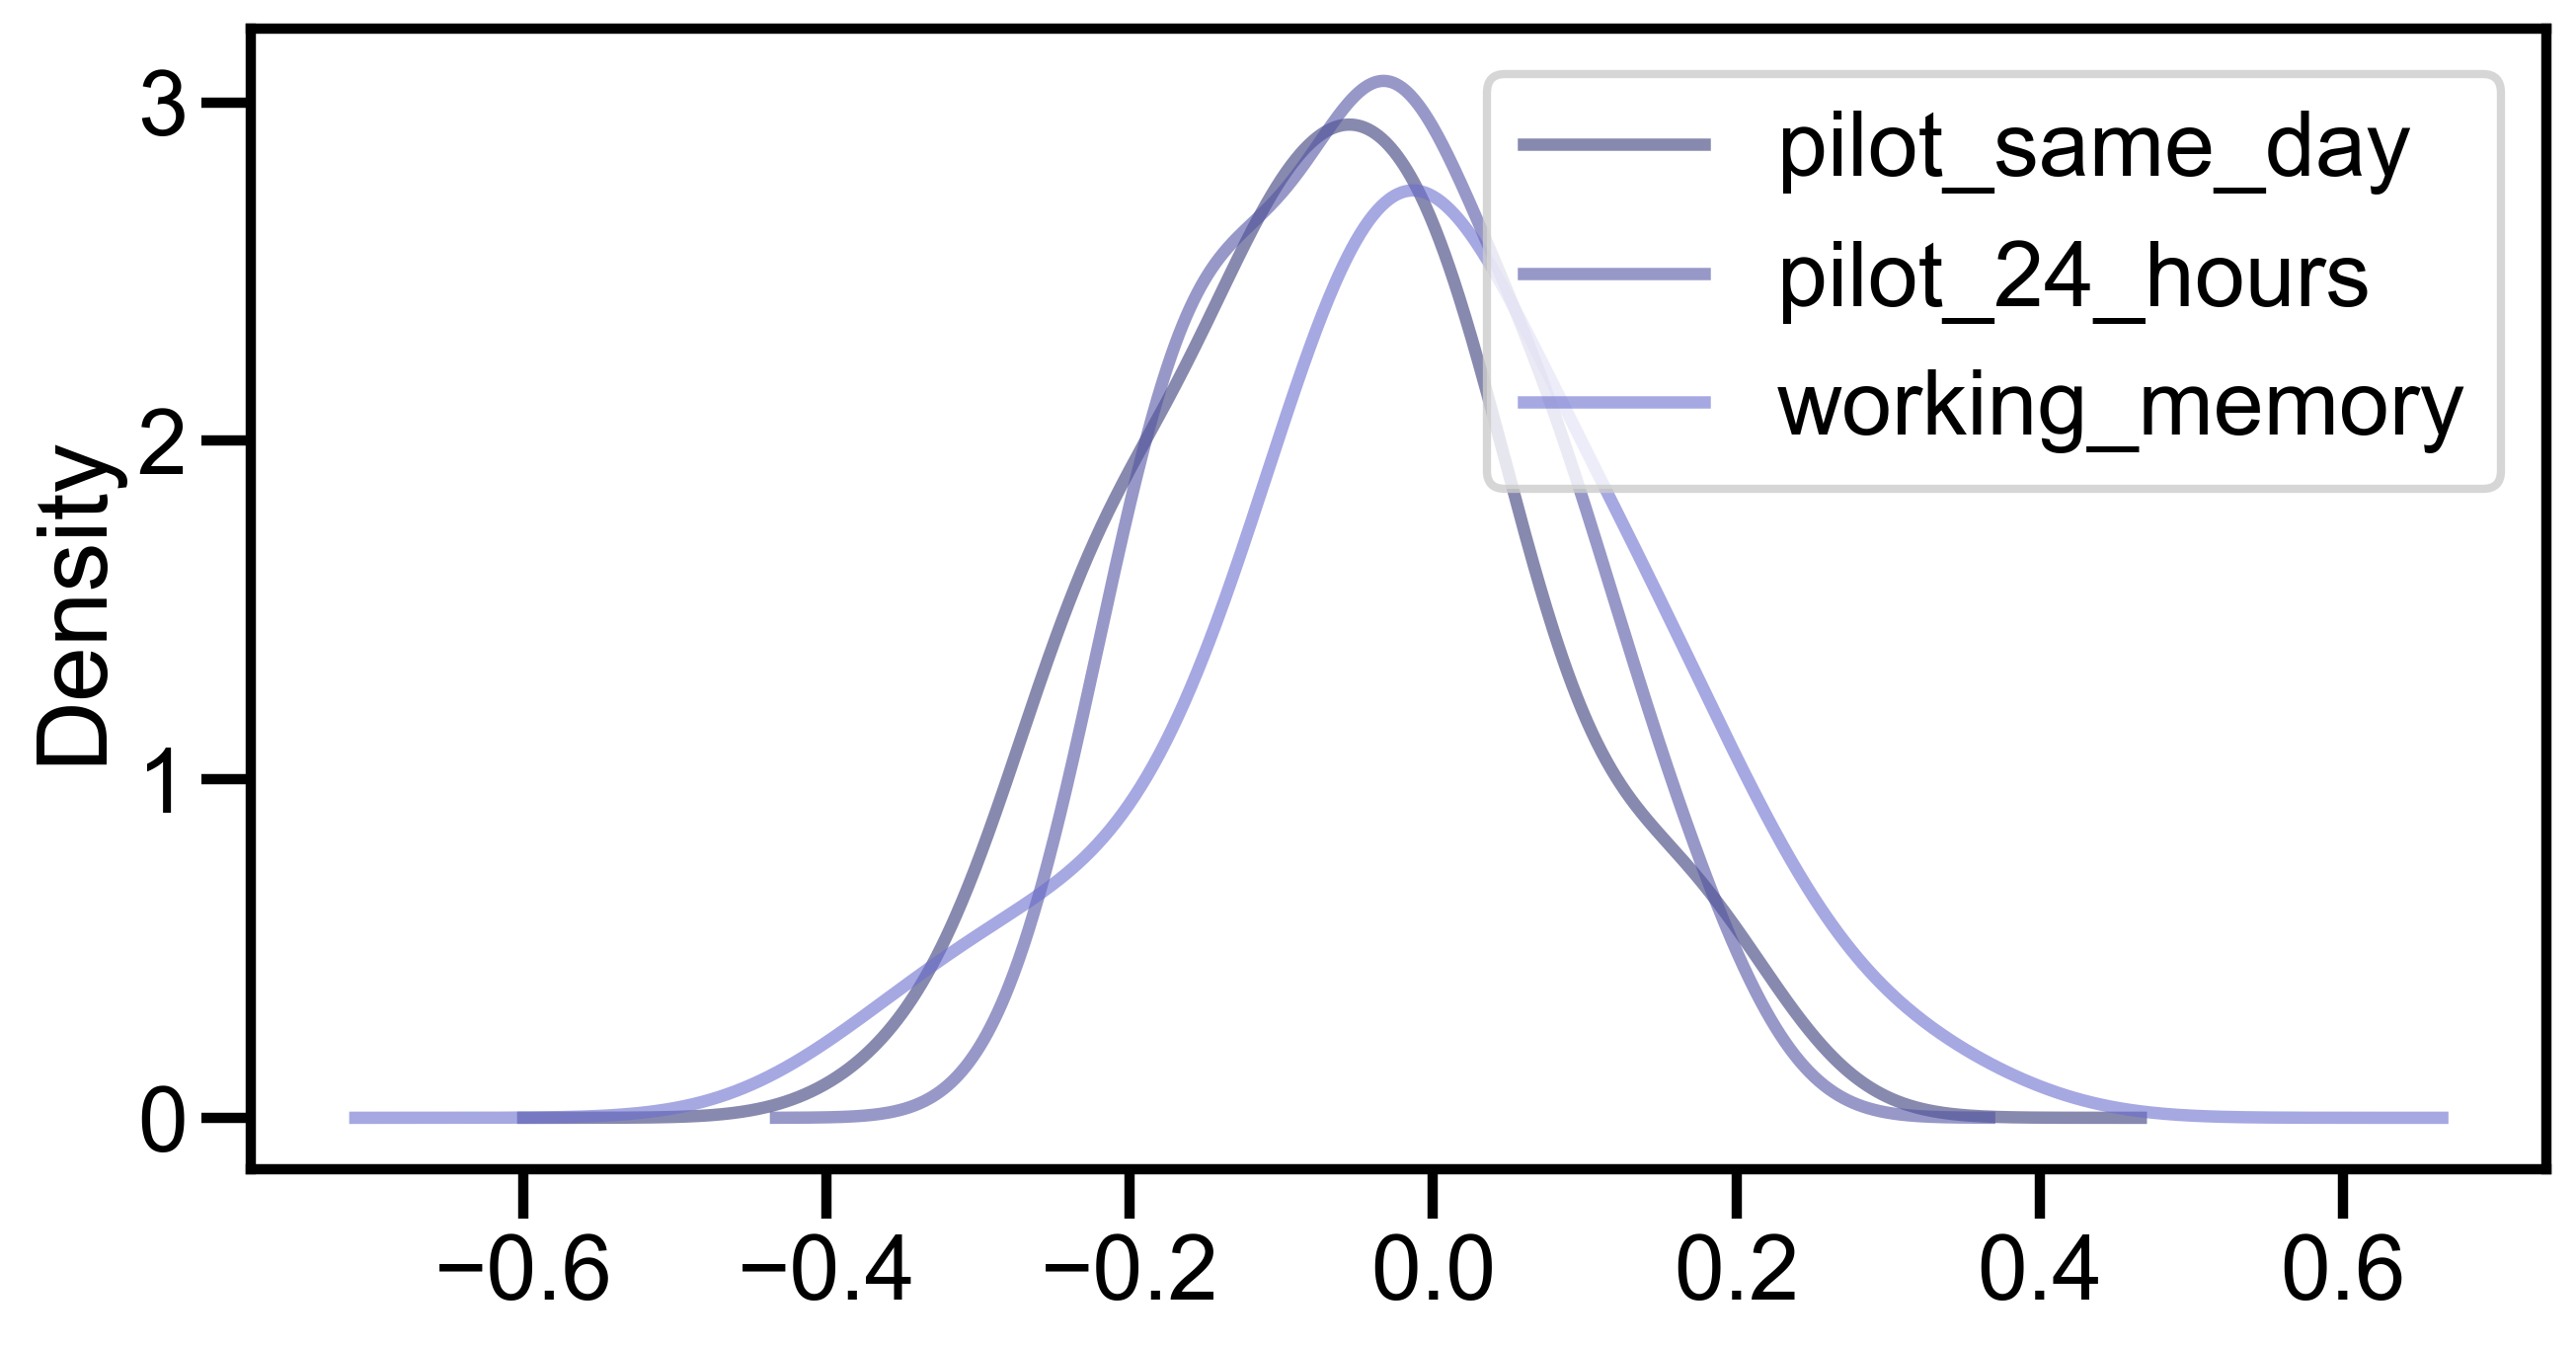

In [91]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()

for time_gap in all_subjects_working_memory_and_time_gaps['time_gap'].unique():
    cur_df = all_subjects_working_memory_and_time_gaps[all_subjects_working_memory_and_time_gaps['time_gap'] == time_gap]
    cur_df['delta'].plot(kind='kde',alpha=0.6,ax=ax,label=time_gap)

plt.legend()  

In [92]:
#create long format dataframes for accuracy and rt seperately
rt_df = pd.melt(all_subjects_working_memory_and_time_gaps,id_vars=['worker_ID','time_gap'],value_vars=['low_level_rt','high_level_rt'],var_name='layer')
accuracy_df = pd.melt(all_subjects_working_memory_and_time_gaps,id_vars=['worker_ID','time_gap'],value_vars=['low_level_accuracy','high_level_accuracy'],var_name='layer')
rating_df = pd.melt(all_subjects_working_memory_and_time_gaps,id_vars=['worker_ID','time_gap'],value_vars=['low_level_rating','high_level_rating'],var_name='layer')

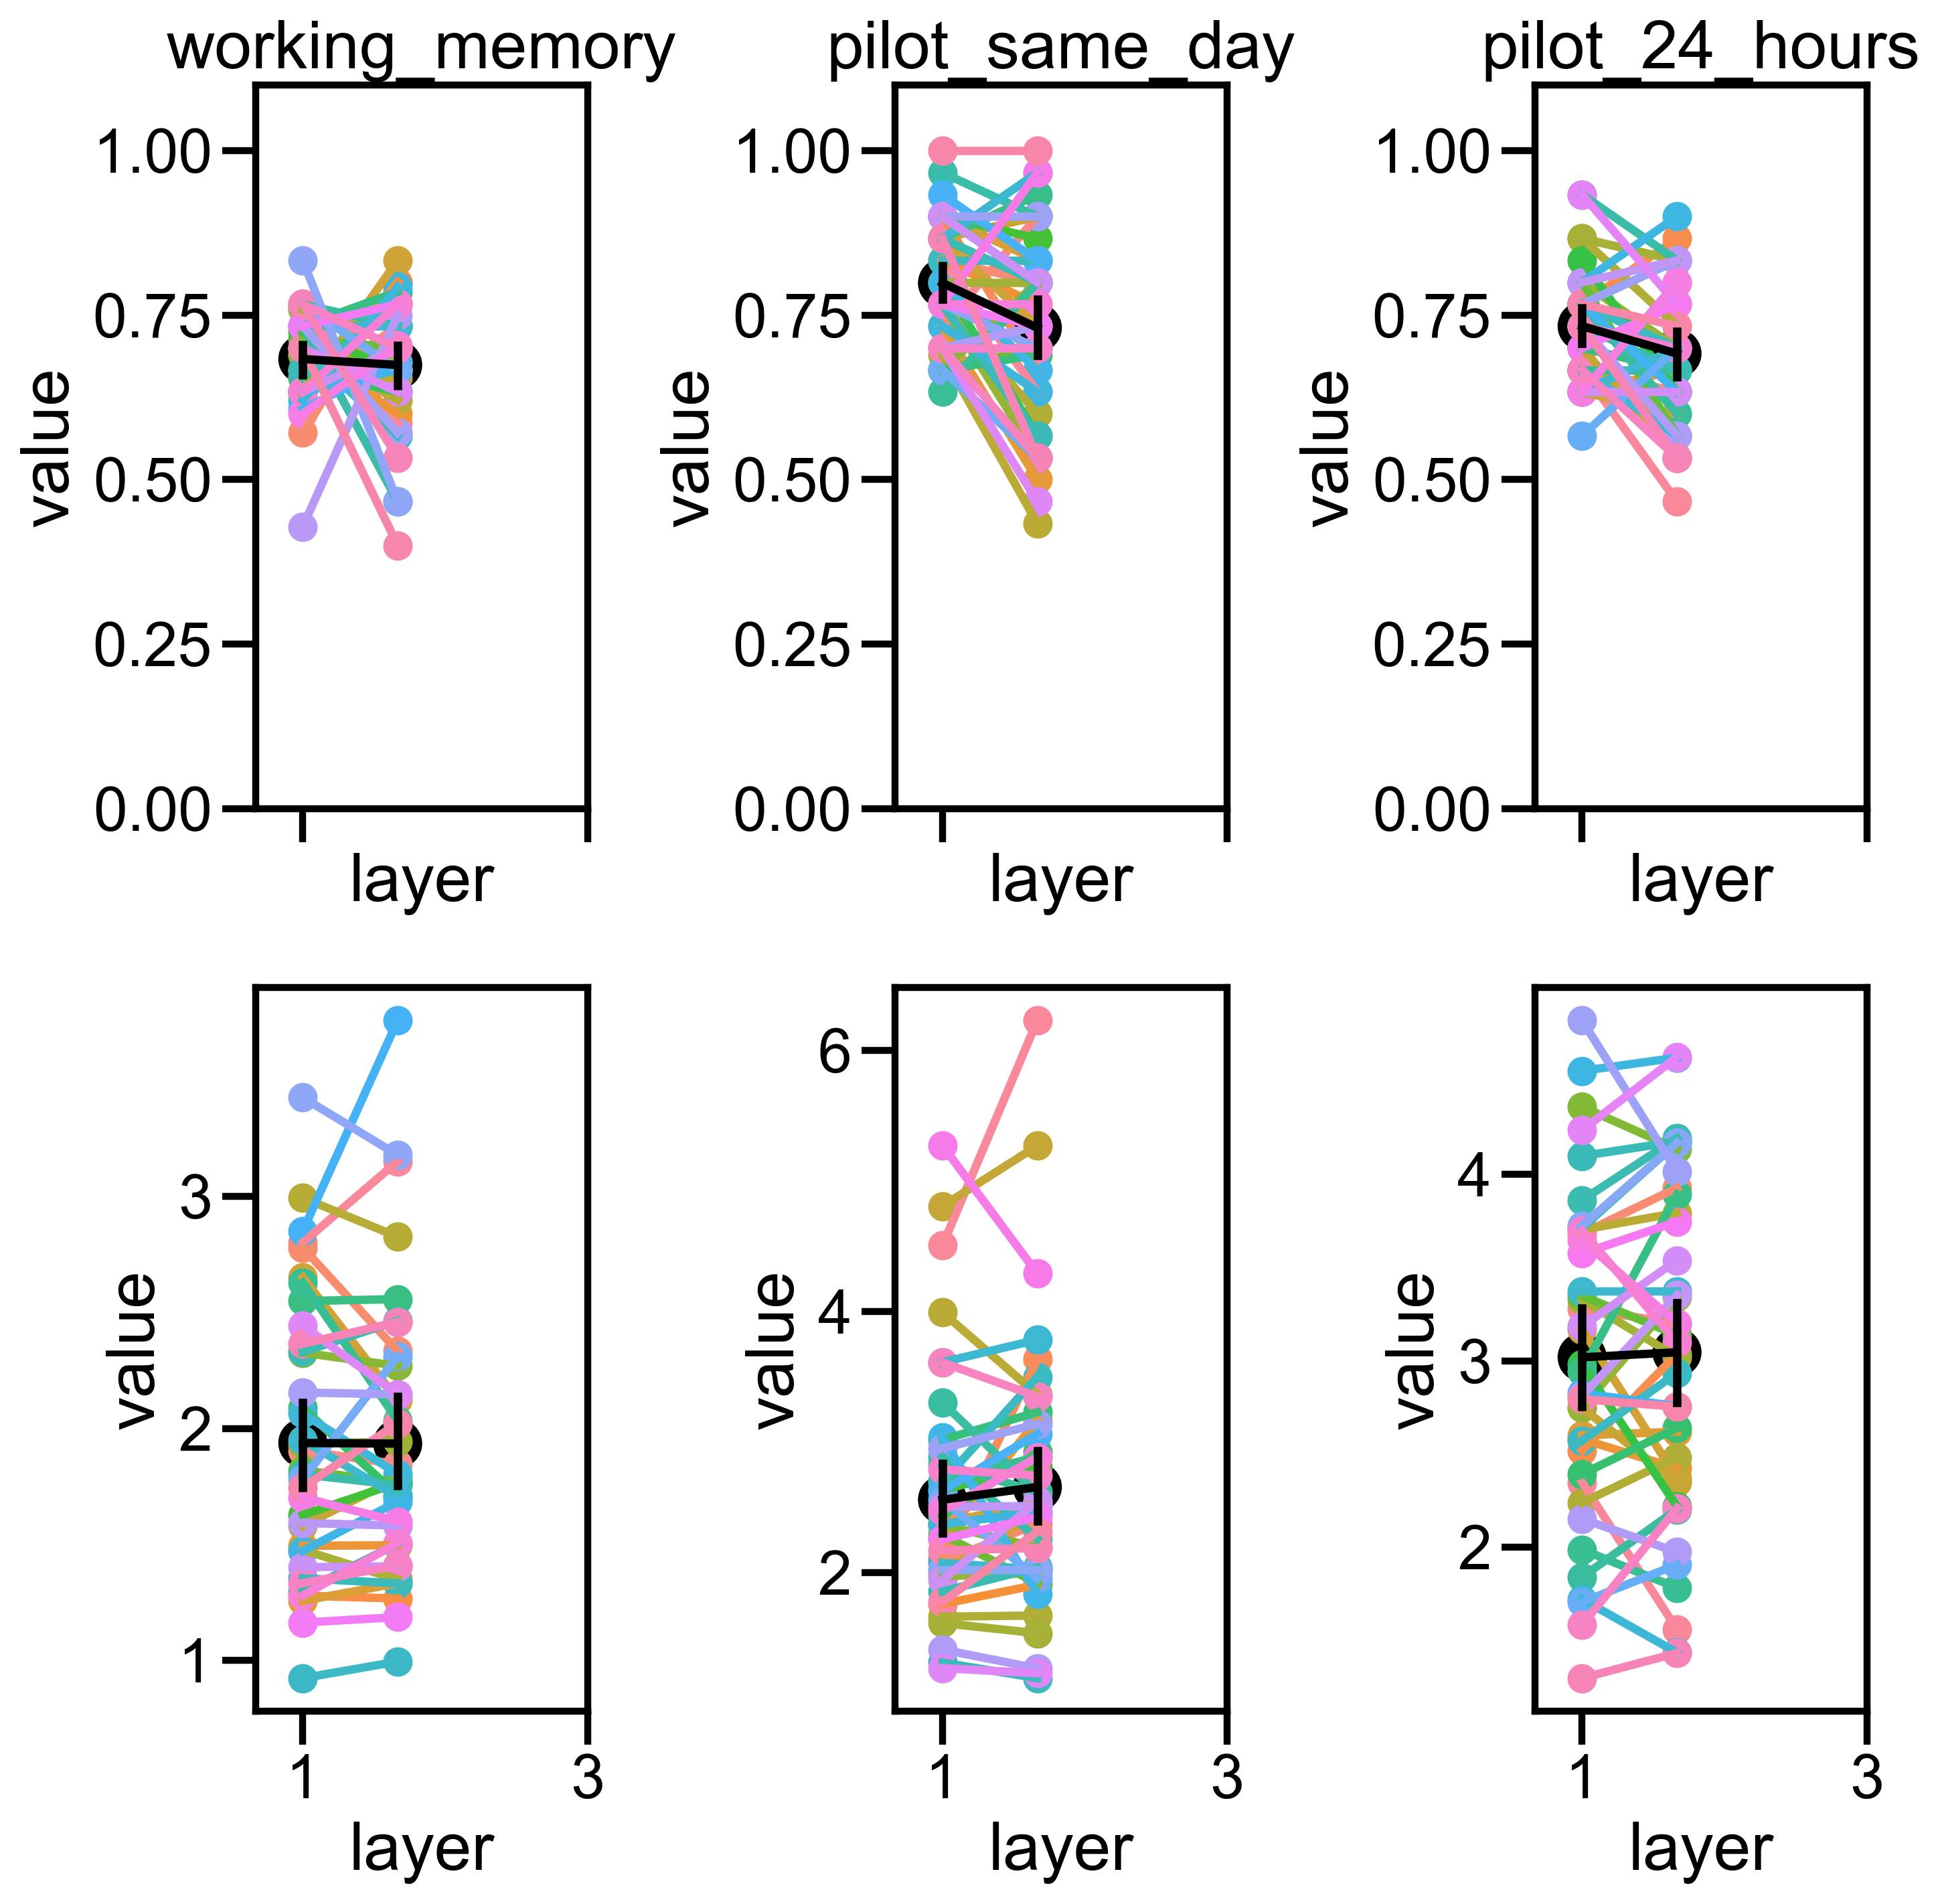

In [93]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(10,10),sharex=True,sharey=False)
my_order = ['working_memory','pilot_same_day','pilot_24_hours']
for i,curtime in enumerate(my_order):
    #accuracy: 
    g=sns.pointplot(data=accuracy_df[accuracy_df['time_gap']==curtime],x='layer', y='value', hue='worker_ID', ax=axes[0,i], scale = 0.6)
    plt.setp(axes[0,i].lines, zorder=100, linewidth=3)
    axes[0,i].set_ylim([0,1.1])
    sns.pointplot(data=accuracy_df[accuracy_df['time_gap']==curtime],x='layer', y='value',ax=axes[0,i],color='black',scale=1)
    plt.setp(axes[0,i].lines, zorder=200, linewidth=3)
    axes[0,i].get_legend().remove() 
    axes[0,i].set_title(curtime)
    #rt: 
    g=sns.pointplot(data=rt_df[rt_df['time_gap']==curtime],x='layer', y='value', hue='worker_ID', ax=axes[1,i], scale = 0.6)
    plt.setp(axes[1,i].lines, zorder=100, linewidth=3)
    sns.pointplot(data=rt_df[rt_df['time_gap']==curtime],x='layer', y='value',ax=axes[1,i],color='black',scale=1)
    plt.setp(axes[1,i].lines, zorder=200, linewidth=3)
    plt.xticks([0,3],['1','3'])
    axes[1,i].get_legend().remove()

plt.tight_layout()
fig.savefig(PATH_TO_EXPERIMENT / ('line_graphs_per_condition_in_seperate_subplots_'+qualification_method+'.svg'))


In [94]:
def add_connecting_lines_to_stripplot(stripplot_handle,ax):
  #get the current offsets:
  paths = stripplot_handle.collections
  #get x offsets:
  x_offsets = [path.get_offsets()[:,0] for path in paths if len(path.get_offsets()[:,0])>0]
  x_offsets_arrays=[np.array(offsets) for offsets in x_offsets]
  #get y offsets:
  y_offsets = [path.get_offsets()[:,1] for path in paths  if len(path.get_offsets()[:,1])>0]
  y_offsets_arrays=[np.array(offsets) for offsets in y_offsets ]
  # Connect each pair of points from the same row with a line
  for i in range(len(x_offsets_arrays[0])):
    ax.plot([x_offsets_arrays[0][i], x_offsets_arrays[0+1][i]], [y_offsets_arrays[0][i], y_offsets_arrays[0+1][i]], color="black", alpha=0.75,linestyle='dashed',linewidth=0.5)

  for i in range(len(x_offsets_arrays[2])):
    ax.plot([x_offsets_arrays[2][i], x_offsets_arrays[2+1][i]], [y_offsets_arrays[2][i], y_offsets_arrays[2+1][i]], color="black", alpha=0.75,linestyle='dashed',linewidth=0.5)

  # this is an additions for when there are 3 bars to plot (3 time gaps) 3 bars with 2 subbars 
  if len(x_offsets_arrays) == 6:
    for i in range(len(x_offsets_arrays[4])):
      ax.plot([x_offsets_arrays[4][i], x_offsets_arrays[4+1][i]], [y_offsets_arrays[4][i], y_offsets_arrays[4+1][i]], color="black", alpha=0.75,linestyle='dashed',linewidth=0.5)

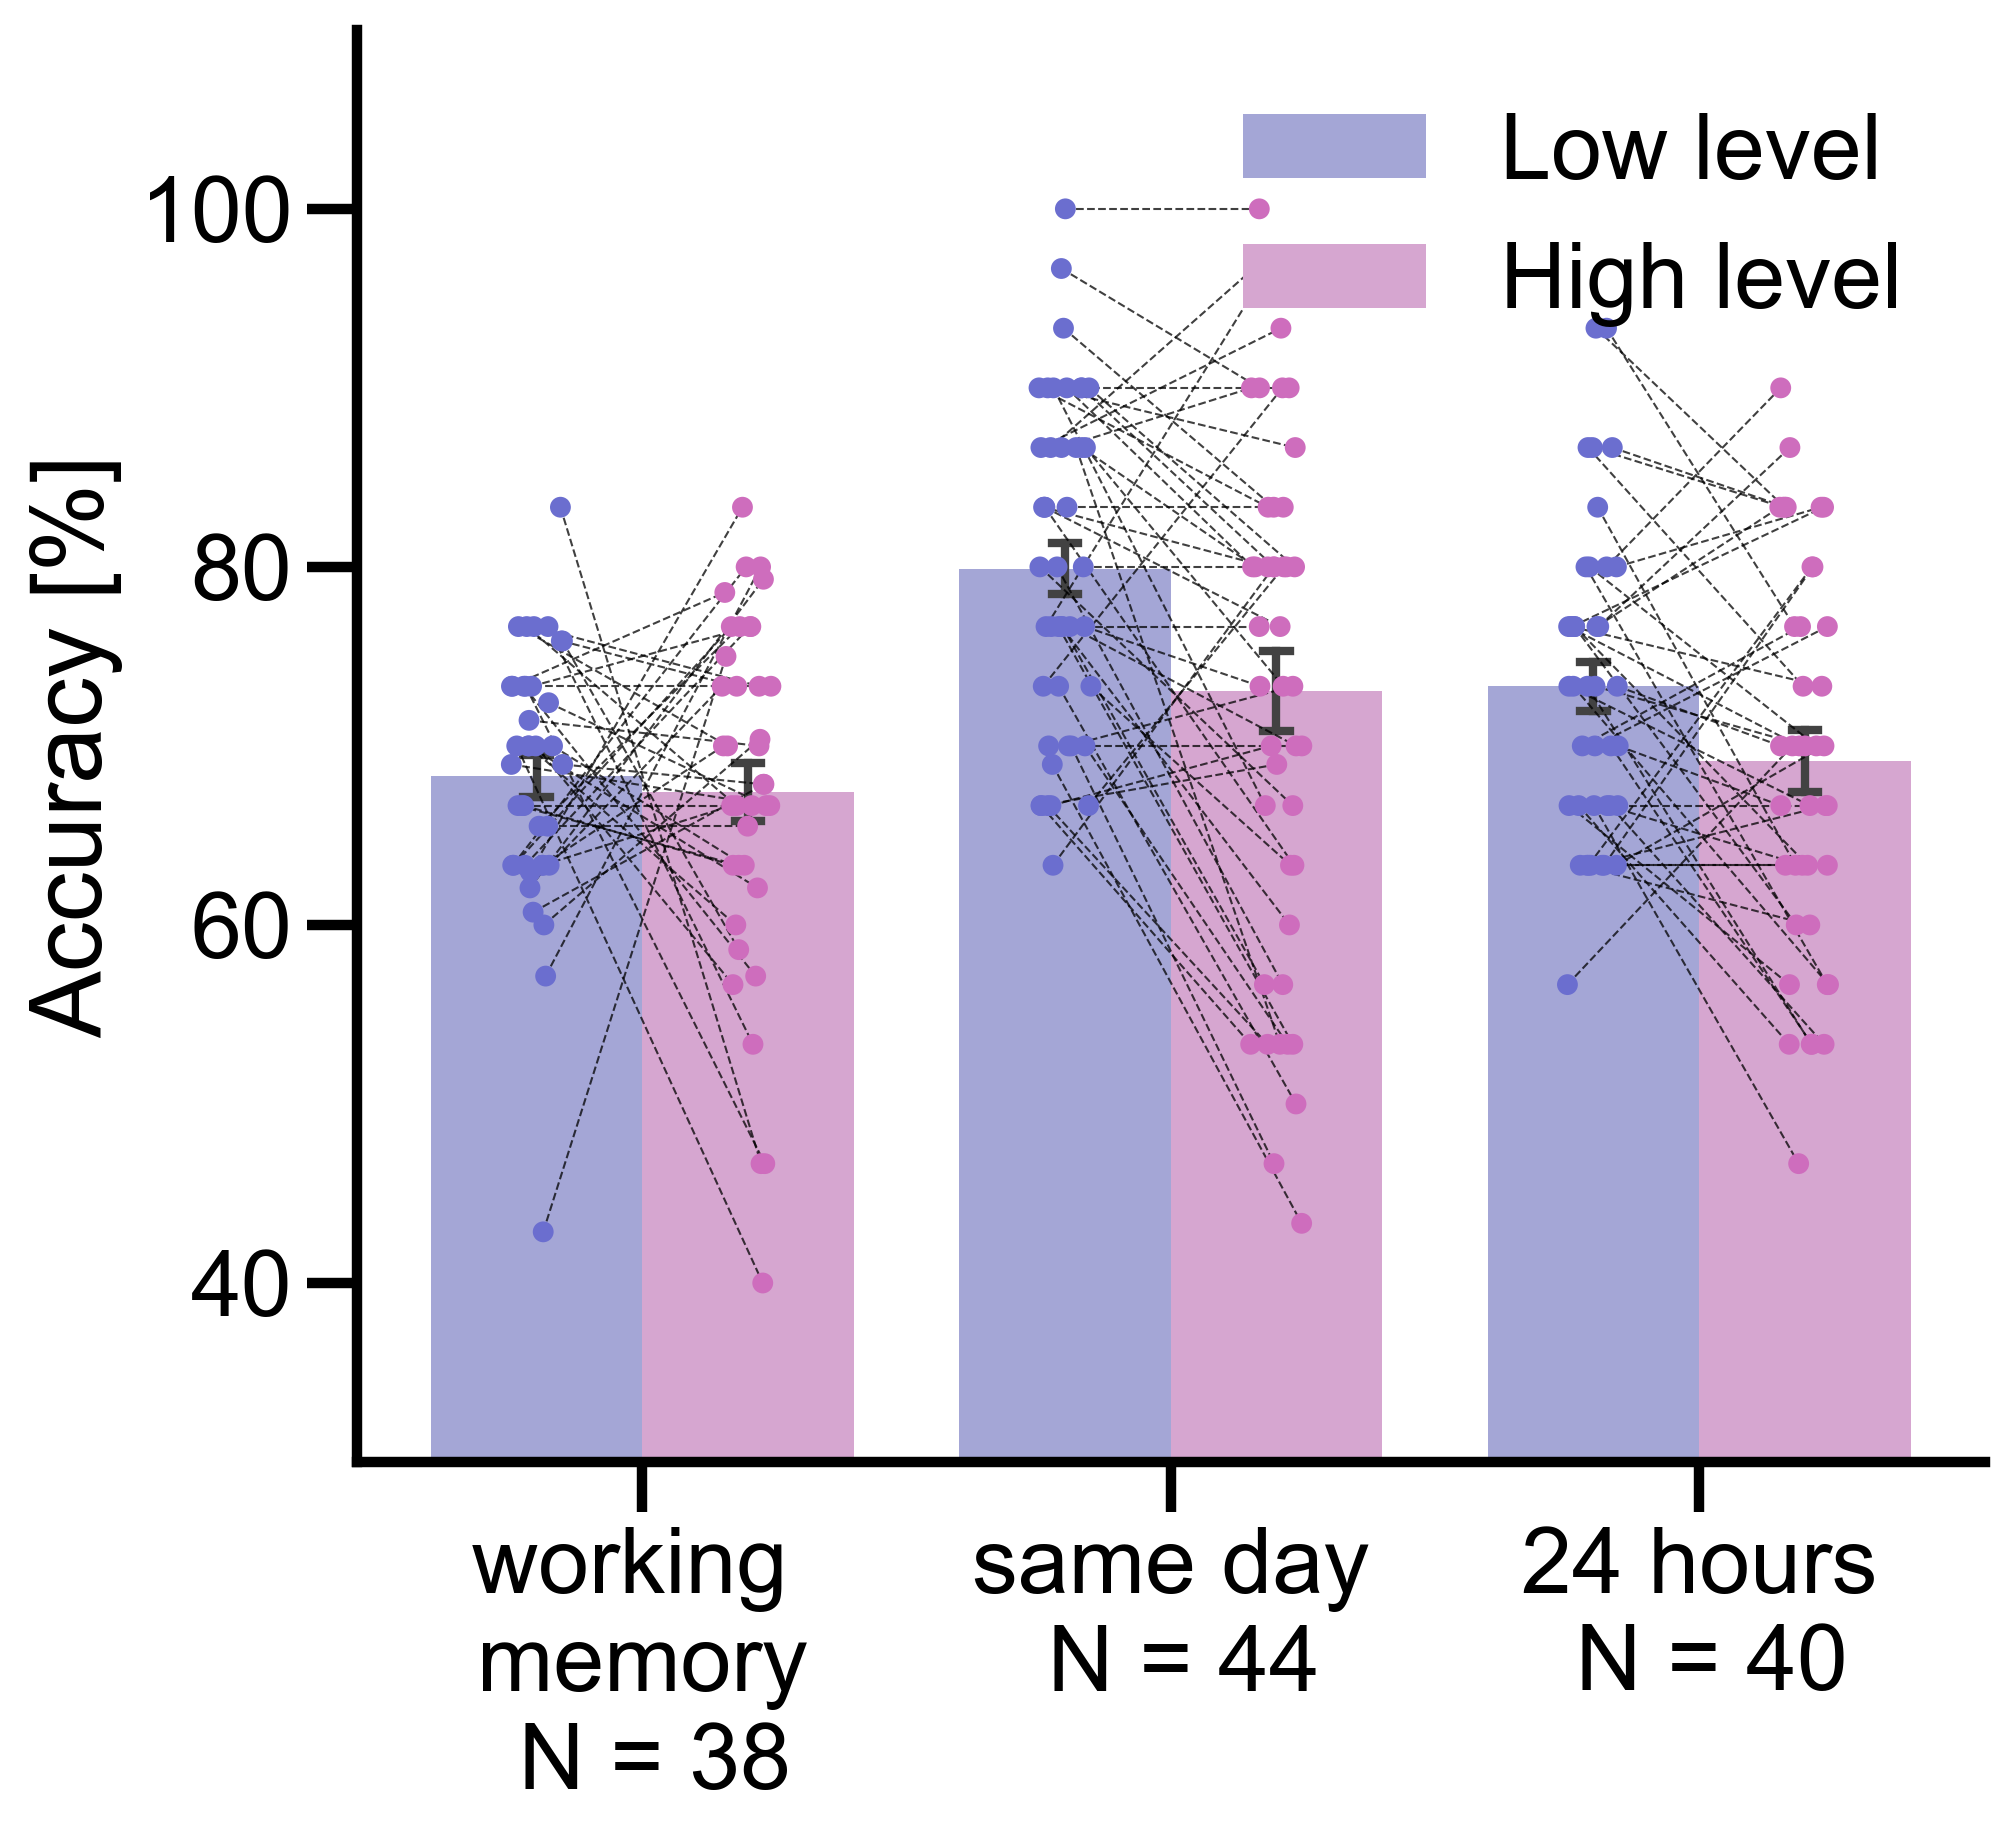

In [95]:
#code for figures:
my_order = ['low_level_accuracy','high_level_accuracy']

if accuracy_df['value'].mean()<1:
    accuracy_df['value']=accuracy_df['value']*100

fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(7,6.2),gridspec_kw = {'wspace':0.2, 'hspace':0})

bar = sns.barplot(data =accuracy_df, x='time_gap',y='value',hue='layer',ax=axes,palette=[sns.color_palette()[3],sns.color_palette()[-1]],hue_order=my_order,order=['working_memory','pilot_same_day','pilot_24_hours'],errorbar='se', capsize=.05,errwidth=2)
stripplot=sns.stripplot(data =accuracy_df, x='time_gap',y='value',hue='layer',ax=axes,dodge=True,palette=[sns.color_palette()[2],sns.color_palette()[-2]],hue_order=my_order,order=['working_memory','pilot_same_day','pilot_24_hours'])

# Hide the right and top spines
axes.spines[['right', 'top']].set_visible(False)

# axes[0].set_xticklabels(labels=['pilot_same_day','pilot_24_hours','pilot_one_week'],rotation=30)
axes.set_xlabel('')
axes.set_xticklabels(labels=[f'working \nmemory\n N = {n_working_memory}',f'same day\n N = {n_same_day}',f'24 hours\n N = {n_24_hours}'])
# Rotating X-axis labels
#plt.xticks(rotation = -45)
handles, labels = axes.get_legend_handles_labels()
legend = axes.legend(handles[2:],['Low level','High level'],loc='upper right', facecolor='none', framealpha=0)
# create the legend and set its facecolor and alpha values

# set the alpha value of the legend text
for text in legend.get_texts():
    text.set_alpha(1)


add_connecting_lines_to_stripplot(stripplot,axes)
axes.set_ylabel('Accuracy [%]')
axes.set_ylim([30,110])
fig.patch.set_alpha(0)


fig.savefig(PATH_TO_EXPERIMENT / ('all_batches_bar_graph_grouped_by_timegap_'+qualification_method+'.svg'))
fig.savefig(PATH_TO_EXPERIMENT / ('all_batches_bar_graph_grouped_by_timegap_'+qualification_method+'.pdf'), transparent=True)
fig.savefig(PATH_TO_EXPERIMENT / ('all_batches_bar_graph_grouped_by_timegap_'+qualification_method+'.png'), transparent=True)


### check what percent of subejcts in each time gap have low value larger than high 

In [96]:
working = accuracy_df[accuracy_df['time_gap'] == 'pilot_24_hours']
low = working[working['layer'] == 'low_level_accuracy']
high = working[working['layer'] == 'high_level_accuracy']

In [97]:
sum(low['value'].values > high['value'].values)/low.shape[0]

0.625

# Statistics 

### create a csv file for spss analysis 

In [98]:
#this cell merges the accuracy and rating dataframes (averged per participant) suitable for a mixed ancova in spss: 
#spss wants within-subject factors are different columns (within the same row), and between subject factors as between rows - the following code creates table suitable for spss statistics
merged_df_for_spss=pd.merge(accuracy_df.query('layer=="low_level_accuracy"'),accuracy_df.query('layer=="high_level_accuracy"'),on='worker_ID')
merged_df_for_spss.rename(columns={'value_x':'low_level_accuracy','value_y':'high_level_accuracy'},inplace=True)
merged_df_for_spss.drop(columns=['time_gap_x','layer_x','layer_y'],inplace=True)


merged_df_for_spss_rating=pd.merge(rating_df.query('layer=="low_level_rating"'),rating_df.query('layer=="high_level_rating"'),on='worker_ID')
merged_df_for_spss_rating.rename(columns={'value_x':'low_level_rating','value_y':'high_level_rating'},inplace=True)
merged_df_for_spss_rating.drop(columns=['time_gap_x','layer_x','layer_y'],inplace=True)
#
final_spss_df=pd.merge(merged_df_for_spss,merged_df_for_spss_rating,on='worker_ID')
#reorder columns: 
final_spss_df=final_spss_df.reindex(columns=['worker_ID','time_gap_y_y','low_level_accuracy','high_level_accuracy','low_level_rating','high_level_rating'])
final_spss_df.to_csv('data_for_spss.csv',index=False)

display(final_spss_df.head())

worker_ID    time_gap_y_y  low_level_accuracy  high_level_accuracy  low_level_rating  high_level_rating
0  A17K1CHOI773VZ  pilot_same_day           83.333333            63.333333          4.033333           4.900000
1   AMHUDJ44HF1ZH  pilot_same_day           73.333333            90.000000          6.033333           7.366667
2   AGOBQY50VQ7VX  pilot_same_day           83.333333            80.000000          6.733333           6.733333
3  A23J0G72AUTS1I  pilot_same_day           90.000000            66.666667          6.666667           6.200000
4   ATPW1MWLW7RBL  pilot_same_day           83.333333            76.666667          5.966667           6.033333

In [99]:
all_directories_paths_long_term_memory = [path.Path(cur_path) for cur_path in all_directories_paths_long_term_memory]
all_directories_paths_working_memory = [path.Path(cur_path) for cur_path in all_directories_paths_working_memory]
all_participants_batch_locations = all_directories_paths_working_memory + all_directories_paths_long_term_memory

## creating long format data structures (per trial) for correlation analysis
## long format long term memory

In [100]:
#create a long format encoding and test dataframes: 
all_subjects_encoding_long_format_df_long_term=pd.DataFrame()
all_subjects_test_long_format_df_long_term=pd.DataFrame()
for cur_batch in all_directories_paths_long_term_memory:
    print(cur_batch)
    cur_sub_encoding_df=pd.read_csv(cur_batch / 'all_subjects_encoding_df.csv')
    cur_sub_test_df=pd.read_csv(cur_batch / 'all_subjects_test_df.csv')
    cur_sub_biographics=pd.read_csv(cur_batch / 'all_subjects_biographics_df.csv')

    cur_sub_encoding_df['time_gap']=cur_batch.parent.name
    cur_sub_test_df['time_gap']=cur_batch.parent.name

    # the data is trial-by-trial , so to concate the age and gender we need to multiple the values for the whole trials
    cur_sub_biographics['Gender'].fillna('Unknown',inplace=True)
    gender_list=[[cur_gen[0].upper()]*cur_sub_test_df['subject'].value_counts().values[i] for i,cur_gen in enumerate(cur_sub_biographics['Gender'].values)]
    gender_list = np.array(gender_list).flatten()

    age_list=[[cur_age]*cur_sub_test_df['subject'].value_counts().values[i] for i,cur_age in enumerate(cur_sub_biographics['Age'].values)]
    age_list = np.array(age_list).flatten()

    cur_sub_test_df['Age'] = age_list
    cur_sub_test_df['Gender'] = gender_list

    all_subjects_encoding_long_format_df_long_term=pd.concat([all_subjects_encoding_long_format_df_long_term,cur_sub_encoding_df],axis=0)
    all_subjects_test_long_format_df_long_term=pd.concat([all_subjects_test_long_format_df_long_term,cur_sub_test_df],axis=0)



# here we create a df with only the valid subjects (those that didnt get disqualified from the exclusion criteria)
all_valid_test_df_long_format_long_term=pd.DataFrame()
all_valid_encoding_df_long_format_ling_term=pd.DataFrame()

for cur_sub in all_valid_subjects_non_working_memory.index:
    #some subject names are the full length name to thier csv: if this is the case, change it to take only the amazong worker id: 
    cur_sub_encoding=all_subjects_encoding_long_format_df_long_term[all_subjects_encoding_long_format_df_long_term['subject']==cur_sub]
    cur_sub_test=all_subjects_test_long_format_df_long_term[all_subjects_test_long_format_df_long_term['subject']==cur_sub]
    all_valid_encoding_df_long_format_ling_term=pd.concat([all_valid_encoding_df_long_format_ling_term,cur_sub_encoding],axis=0)
    all_valid_test_df_long_format_long_term=pd.concat([all_valid_test_df_long_format_long_term,cur_sub_test],axis=0)

print('only valid participants counts:')
print(all_valid_test_df_long_format_long_term['time_gap'].value_counts())
print('all participants counts:')
print(all_subjects_test_long_format_df_long_term['time_gap'].value_counts())


/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_same_day/batch 1
/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_same_day/batch 2
/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_24_hours/batch 1
/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_24_hours/batch 3
/Users/edenzohar/Thesis/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_24_hours/batch 2
only valid participants counts:
time_gap
pilot_same_day    2640
pilot_24_hours    2520
Name: count, dtype: int64
all participants counts:
time_gap
pilot_same_day    5280
pilot_24_hours    4800
Name: count, dtype: int64


# long format working memroy 

In [101]:
#create a long format encoding and test dataframes: 
all_subjects_test_long_format_df_working_memory=pd.DataFrame()
for cur_batch in all_directories_paths_working_memory:
    
    cur_sub_test_df=pd.read_csv(cur_batch / 'all_subjects_rating_and_accuracy_df.csv')
    cur_sub_test_df['Gender'].fillna('Unknown',inplace=True)
    cur_sub_test_df['Gender'] = cur_sub_test_df['Gender'].apply(lambda x: x[0].upper())
    cur_sub_test_df['time_gap']='working_memory'
    all_subjects_test_long_format_df_working_memory=pd.concat([all_subjects_test_long_format_df_working_memory,cur_sub_test_df],axis=0)


all_valid_test_df_long_format_working_memory=pd.DataFrame()

for cur_sub in all_valid_subjects_working_memory.index:

    cur_sub_test=all_subjects_test_long_format_df_working_memory[all_subjects_test_long_format_df_working_memory['subject']==cur_sub]
    all_valid_test_df_long_format_working_memory=pd.concat([all_valid_test_df_long_format_working_memory,cur_sub_test],axis=0)

print('only valid participants counts:')
print(all_valid_test_df_long_format_working_memory['time_gap'].value_counts())
print('all participants counts:')
print(all_subjects_test_long_format_df_working_memory['time_gap'].value_counts())


only valid participants counts:
time_gap
working_memory    2460
Name: count, dtype: int64
all participants counts:
time_gap
working_memory    7920
Name: count, dtype: int64


### make sure to not include subjects that are duplicate / have been disqualified:

In [102]:
valid_work_ids_working_memory = accuracy_df[accuracy_df['time_gap'] == 'working_memory']['worker_ID'].values
valid_work_ids_long_term_memory = accuracy_df[accuracy_df['time_gap'] != 'working_memory']['worker_ID'].values

all_valid_test_df_long_format_working_memory = all_valid_test_df_long_format_working_memory[all_valid_test_df_long_format_working_memory['subject'].isin(valid_work_ids_working_memory)]
all_valid_test_df_long_format_long_term = all_valid_test_df_long_format_long_term[all_valid_test_df_long_format_long_term['subject'].isin(valid_work_ids_long_term_memory)]

In [104]:
all_valid_test_df_long_format_long_term = all_valid_test_df_long_format_long_term[~((all_valid_test_df_long_format_long_term['subject'] == 'AEK2SAEL9GG39') & (all_valid_test_df_long_format_long_term['time_gap'] == 'pilot_24_hours')) ]
all_valid_test_df_long_format_long_term = all_valid_test_df_long_format_long_term[~((all_valid_test_df_long_format_long_term['subject'] == 'A39KMTFHRJJASK') & (all_valid_test_df_long_format_long_term['time_gap'] == 'pilot_24_hours')) ]

In [105]:
all_valid_test_df_long_format_long_term['subject'].value_counts()

subject
A17K1CHOI773VZ    60
A2IQ0QCTQ3KWLT    60
AW07POT8ABE05     60
AC01SVLHOB6HN     60
A1969Q0R4Y0E3J    60
                  ..
AZNIEFUIVB2H0     60
A1VXAJIELTYK0     60
A3CGQOJC28OVGN    60
A23KAJRDVCVGOE    60
A2J9NFY45NKR2N    60
Name: count, Length: 84, dtype: int64

In [106]:
all_valid_test_df_long_format_working_memory['correct_numeric'] = all_valid_test_df_long_format_working_memory['correct'] == all_valid_test_df_long_format_working_memory['test_key_resp.keys'] 

In [107]:
all_valid_test_df_long_format_working_memory['correct_numeric'] = all_valid_test_df_long_format_working_memory['correct_numeric'].apply(lambda x: int(x))

## add the selected dist,target and category columns 

In [108]:
targets = []
distractors = []
for row in all_valid_test_df_long_format_long_term.iterrows():
    correct = row[1]['correct']
    if correct == 'left':
        target = row[1]['image1']
        distractor = row[1]['image2']
    else: 
        target = row[1]['image2']
        distractor = row[1]['image1']
    
    targets.append(target)
    distractors.append(distractor)


all_valid_test_df_long_format_long_term['target'] = targets 
all_valid_test_df_long_format_long_term['selected_dist'] = distractors

In [109]:
all_valid_test_df_long_format_long_term['category'] = all_valid_test_df_long_format_long_term['target'].apply(lambda x: x.split('_')[0])

In [110]:
new_cols = {'bar_2.response':'slider_part2.response',
            'layer':'distractor_level',
            'test_test_response.keys':'test_key_resp.keys',
            
            'test_test_response.rt':'test_key_resp.rt',
            'test_test_response.corr': 'correct_numeric',
            
}

all_valid_test_df_long_format_long_term.rename(columns=new_cols,inplace=True)

In [111]:
df_long_format_all_time_gaps = pd.concat([all_valid_test_df_long_format_long_term,all_valid_test_df_long_format_working_memory])

df_long_format_all_time_gaps.rename(columns={'slider_part2.response':'rating'},inplace=True)
display(df_long_format_all_time_gaps)

Unnamed: 0  distractor_level correct test_key_resp.keys  correct_numeric  test_key_resp.rt  trials_2.thisRepN  trials_2.thisTrialN  trials_2.thisN  trials_2.thisIndex  trials_2.ran              image1               image2    rating         subject        time_gap  Age Gender               target       selected_dist    category          workID        background_0     background_1         background_2        background_3        background_4        background_5  target_index  slider_part2.rt
0              0               1.0   right              right              1.0            5.9214                0.0                  0.0             0.0                 0.0           1.0     highway_122.jpg      highway_209.jpg  8.000000  A17K1CHOI773VZ  pilot_same_day   34      M      highway_209.jpg     highway_122.jpg     highway             NaN                 NaN              NaN                  NaN                 NaN                 NaN                 NaN           NaN              NaN
1              1               0.0    left               left              1.0            3.3594                0.0                  1.0             1.0                 1.0           1.0      bridge_172.jpg        bridge_17.jpg  2.000000  A17K1CHOI773VZ  pilot_same_day   34      M       bridge_172.jpg       bridge_17.jpg      bridge             NaN                 NaN              NaN                  NaN                 NaN                 NaN                 NaN           NaN              NaN
2              2               1.0    left               left              1.0            7.6472                0.0                  2.0             2.0                 2.0           1.0    badlands_113.jpg     badlands_203.jpg  7.000000  A17K1CHOI773VZ  pilot_same_day   34      M     badlands_113.jpg    badlands_203.jpg    badlands             NaN                 NaN              NaN                  NaN                 NaN                 NaN                 NaN           NaN              NaN
3              3               1.0   right              right              1.0            3.5539                0.0                  3.0             3.0                 3.0           1.0  playground_205.jpg   playground_219.jpg  5.000000  A17K1CHOI773VZ  pilot_same_day   34      M   playground_219.jpg  playground_205.jpg  playground             NaN                 NaN              NaN                  NaN                 NaN                 NaN                 NaN           NaN              NaN
4              4               1.0   right               left              0.0            5.7232                0.0                  4.0             4.0                 4.0           1.0  golf_course_26.jpg  golf_course_331.jpg  6.000000  A17K1CHOI773VZ  pilot_same_day   34      M  golf_course_331.jpg  golf_course_26.jpg        golf             NaN                 NaN              NaN                  NaN                 NaN                 NaN                 NaN           NaN              NaN
...          ...               ...     ...                ...              ...               ...                ...                  ...             ...                 ...           ...                 ...                  ...       ...             ...             ...  ...    ...                  ...                 ...         ...             ...                 ...              ...                  ...                 ...                 ...                 ...           ...              ...
3595        3595               1.0   right               left              0.0            1.4125                NaN                  NaN             NaN                 NaN           NaN     highway_369.jpg       highway_93.jpg  7.764444  A1ZFUHVIPQOVGK  working_memory   35      F       highway_93.jpg     highway_369.jpg     highway  A1ZFUHVIPQOVGK     mountain_84.jpg   highway_93.jpg  golf_course_159.jpg   playground_30.jpg   playground_30.jpg   playground_30.jpg           1.0           1.7986
3596  

In [112]:
dummies_timegaps = pd.get_dummies(df_long_format_all_time_gaps['time_gap'], prefix='time_gap')
if dummies_timegaps.columns[0] in df_long_format_all_time_gaps.columns:
    print('dummies were previously added, not re-adding them')
    print(f'dummy column names: {dummies_timegaps.columns}')
else: 
    print(f'adding dummy columns: {dummies_timegaps.columns}')
    df_long_format_all_time_gaps=pd.concat([df_long_format_all_time_gaps,dummies_timegaps],axis=1)

adding dummy columns: Index(['time_gap_pilot_24_hours', 'time_gap_pilot_same_day',
       'time_gap_working_memory'],
      dtype='object')


In [ ]:
#this cell tries to use generlized mixed models to add random effects (for subjects) and to use single trials instad of aggregate statistics: 
#note, that its a baysian model that is a logistic model (predicting probabilities)
# this code dosent work 
'''
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

random = {"a": '0 + C(subject)'}
model1 = BinomialBayesMixedGLM.from_formula(
            'correct_numeric ~ time_gap_pilot_24_hours+time_gap_pilot_same_day+distractor_level' , random, df_long_format_all_time_gaps)
result1 = model1.fit_vb()
predicted_values1 = result1.predict(df_long_format_all_time_gaps[['time_gap_pilot_24_hours','time_gap_pilot_same_day','distractor_level']])
print(result1.summary())

random = {"a": '0 + C(subject)'}
model2 = BinomialBayesMixedGLM.from_formula(
            'correct_numeric ~ time_gap_pilot_24_hours*distractor_level + time_gap_pilot_same_day*distractor_level', random, df_long_format_all_time_gaps)
result2 = model2.fit_vb()
predicted_values2 = result2.predict(df_long_format_all_time_gaps[['time_gap_pilot_24_hours','time_gap_pilot_same_day','distractor_level']])
print(result2.summary())

random = {"a": '0 + C(subject)'}
model3 = BinomialBayesMixedGLM.from_formula(
            'correct_numeric ~ time_gap_pilot_24_hours*distractor_level + time_gap_pilot_same_day*distractor_level+rating', random, df_long_format_all_time_gaps)
result3 = model3.fit_vb()
predicted_values3 = result3.predict(df_long_format_all_time_gaps[['time_gap_pilot_24_hours','time_gap_pilot_same_day','distractor_level','rating']])
print(result3.summary())



#here we creaste a set of predicted values from each nested model to calculate the pval of the likelihood difference between consequtive models
predicted_df=pd.DataFrame({'model1_predictions':predicted_values1,'model2_predictions':predicted_values2,'model3_predictions':predicted_values3,'True_values':df_long_format_all_time_gaps['correct_numeric']})



#this cell tries to result in a p value for model comparison, based on log_likelihood, assuming a chi-square difference
from sklearn.metrics import log_loss
from scipy.stats import chi2
log_likelihoods=[]
prev=0

df_differences=[4,2,1] #the difference in number of paramters between each consequtive nested model (HARD CODED, change if model paramaters are changed)
for i,cur_model_prediction in enumerate(['model1_predictions','model2_predictions','model3_predictions']):
    log_likelihood = log_loss(predicted_df['True_values'], predicted_df[cur_model_prediction],normalize=False)
    print(cur_model_prediction,log_likelihood)

    LR = -2 * (log_likelihood - prev)
    df_diff = df_differences[i]
    # Calculate the p-value using the chi-square distribution
    p_value = 1 - chi2.cdf(LR, df_diff)
    print("Likelihood Ratio Test Statistic:", LR)
    print("Degrees of Freedom Difference:", df_diff)
    print("P-value:", p_value)
    prev=log_likelihood
'''



# mixed effects (1 between (time gap - 3 levels) and 1 within factors (layer representation - 3 levels)) and some assumption checks

In [113]:
#here we do some statistics: mixed effects (1 between (time gap - 3 levels) and 1 within factors (layer representation - 3 levels)) and some assumption checks
import pingouin as pg

#check for sphercity assumption" 
print('\n---sphericity assumption----------')
print(pg.sphericity(data=accuracy_df, dv='value', subject='worker_ID', within='layer')[-1])

#homoscedasticity
print('\n---homoscedasticity assumption---')
for layer_val in accuracy_df['layer'].unique():
    print(f'layer: {layer_val}:')
    print(pg.homoscedasticity(accuracy_df[accuracy_df['layer']==layer_val], dv='value', group='time_gap'))



#assumption of normality: 
print('\n-----normality assumption-------')
accuracy_df['factor_comb']=accuracy_df["layer"] + '_'+accuracy_df["time_gap"]
print(pg.normality(accuracy_df, dv='value', group='factor_comb'))


print('\n---------anova results----------')

print(pg.mixed_anova(dv='value', between='time_gap', within='layer', subject='worker_ID', data=accuracy_df))



---sphericity assumption----------
1.0

---homoscedasticity assumption---
layer: low_level_accuracy:
               W      pval  equal_var
levene  2.740003  0.068646       True
layer: high_level_accuracy:
               W      pval  equal_var
levene  4.721684  0.010634      False

-----normality assumption-------
                                           W      pval  normal
factor_comb                                                   
low_level_accuracy_pilot_same_day   0.955619  0.089200    True
low_level_accuracy_pilot_24_hours   0.951926  0.088344    True
low_level_accuracy_working_memory   0.929096  0.018788   False
high_level_accuracy_pilot_same_day  0.964448  0.190466    True
high_level_accuracy_pilot_24_hours  0.965178  0.250670    True
high_level_accuracy_working_memory  0.944168  0.057275    True

---------anova results----------
        Source           SS  DF1  DF2           MS          F     p-unc       np2  eps
0     time_gap  3105.222149    2  119  1552.611074  10.9442

# ANCOVA 

In [114]:
low_df = accuracy_df[accuracy_df['layer'] == 'low_level_accuracy'] 
high_df = accuracy_df[accuracy_df['layer'] == 'high_level_accuracy']
low_df.set_index('worker_ID',inplace=True,drop=True)
high_df.set_index('worker_ID',inplace=True,drop=True)
delta = low_df['value']- high_df['value']

low_df_rating = rating_df[rating_df['layer'] == 'low_level_rating'] 
high_df_rating = rating_df[rating_df['layer'] == 'high_level_rating']
low_df_rating.set_index('worker_ID',inplace=True,drop=True)
high_df_rating.set_index('worker_ID',inplace=True,drop=True)
delta_rating = low_df_rating['value']- high_df_rating['value']

In [115]:
delta = pd.DataFrame(delta)
delta.reset_index(inplace=True)
delta.rename({'value':'delta'},inplace=True,axis=1)

delta_rating = pd.DataFrame(delta_rating)
delta_rating.reset_index(inplace=True)
delta_rating.rename({'value':'delta_rating'},inplace=True,axis=1)

In [116]:
df_rating_and_acc = pd.merge(accuracy_df,delta,on='worker_ID')
df_rating_and_acc = pd.merge(delta_rating,df_rating_and_acc,on='worker_ID')
df_rating_and_acc = df_rating_and_acc.iloc[0::2][['worker_ID','delta_rating','delta','time_gap']]

In [117]:
# ancova analysis 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Perform mixed-design ANCOVA
formula = 'delta ~ C(time_gap) + delta_rating'
model = ols(formula, data=df_rating_and_acc).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                    sum_sq     df         F    PR(>F)
C(time_gap)     688.545963    2.0  2.125184  0.123959
delta_rating     12.526546    1.0  0.077326  0.781441
Residual      19115.618078  118.0       NaN       NaN


# ttest 

In [118]:
accuracy_df_working_memory = accuracy_df[accuracy_df['time_gap'] == 'working_memory']
accuracy_df_same_day = accuracy_df[accuracy_df['time_gap'] == 'pilot_same_day']
accuracy_df_24_hours = accuracy_df[accuracy_df['time_gap'] == 'pilot_24_hours']


column1 = accuracy_df_working_memory[accuracy_df_working_memory['layer']=='low_level_accuracy']['value'].values
column2 = accuracy_df_working_memory[accuracy_df_working_memory['layer']=='high_level_accuracy']['value'].values
display(pg.ttest(column1, column2, paired=True))

column1 = accuracy_df_same_day[accuracy_df_same_day['layer']=='low_level_accuracy']['value'].values
column2 = accuracy_df_same_day[accuracy_df_same_day['layer']=='high_level_accuracy']['value'].values
display(pg.ttest(column1, column2, paired=True))


column1 = accuracy_df_24_hours[accuracy_df_24_hours['layer']=='low_level_accuracy']['value'].values
column2 = accuracy_df_24_hours[accuracy_df_24_hours['layer']=='high_level_accuracy']['value'].values
display(pg.ttest(column1, column2, paired=True))

T  dof alternative     p-val          CI95%   cohen-d   BF10     power
T-test  0.381631   37   two-sided  0.704918  [-3.93, 5.75]  0.104937  0.187  0.096599

/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


T  dof alternative     p-val          CI95%   cohen-d    BF10     power
T-test  3.655111   43   two-sided  0.000695  [3.06, 10.58]  0.551178  41.064  0.946663

/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/edenzohar/Thesis/visual_memory_representation_final/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


T  dof alternative     p-val         CI95%   cohen-d   BF10     power
T-test  2.44573   39   two-sided  0.019072  [0.72, 7.61]  0.419212  2.361  0.734215

# ratings analysis 

In [119]:


#print(rating_df.groupby('layer').value_counts())
#check for sphercity assumption" 
print('\n---sphericity assumption----------')
print(pg.sphericity(data=rating_df, dv='value', subject='worker_ID', within='layer')[-1])

#homoscedasticity
print('\n---homoscedasticity assumption---')
for layer_val in rating_df['layer'].unique():
    print(f'layer: {layer_val}:')
    print(pg.homoscedasticity(rating_df[rating_df['layer']==layer_val], dv='value', group='time_gap'))



#assumption of normality: 
print('\n-----normality assumption-------')
rating_df['factor_comb']=rating_df["layer"] + '_'+rating_df["time_gap"]
print(pg.normality(rating_df, dv='value', group='factor_comb'))


print('\n---------anova results----------')

print(pg.mixed_anova(dv='value', between='time_gap', within='layer', subject='worker_ID', data=rating_df))



---sphericity assumption----------
1.0

---homoscedasticity assumption---
layer: low_level_rating:
              W      pval  equal_var
levene  2.28136  0.106596       True
layer: high_level_rating:
               W      pval  equal_var
levene  0.435595  0.647907       True

-----normality assumption-------
                                         W      pval  normal
factor_comb                                                 
low_level_rating_pilot_same_day   0.970922  0.326092    True
low_level_rating_pilot_24_hours   0.911057  0.004075   False
low_level_rating_working_memory   0.945245  0.062119    True
high_level_rating_pilot_same_day  0.965896  0.215282    True
high_level_rating_pilot_24_hours  0.874093  0.000366   False
high_level_rating_working_memory  0.973809  0.503935    True

---------anova results----------
        Source         SS  DF1  DF2         MS          F         p-unc       np2  eps
0     time_gap  11.178618    2  119   5.589309   1.438975  2.412672e-01  0.023613

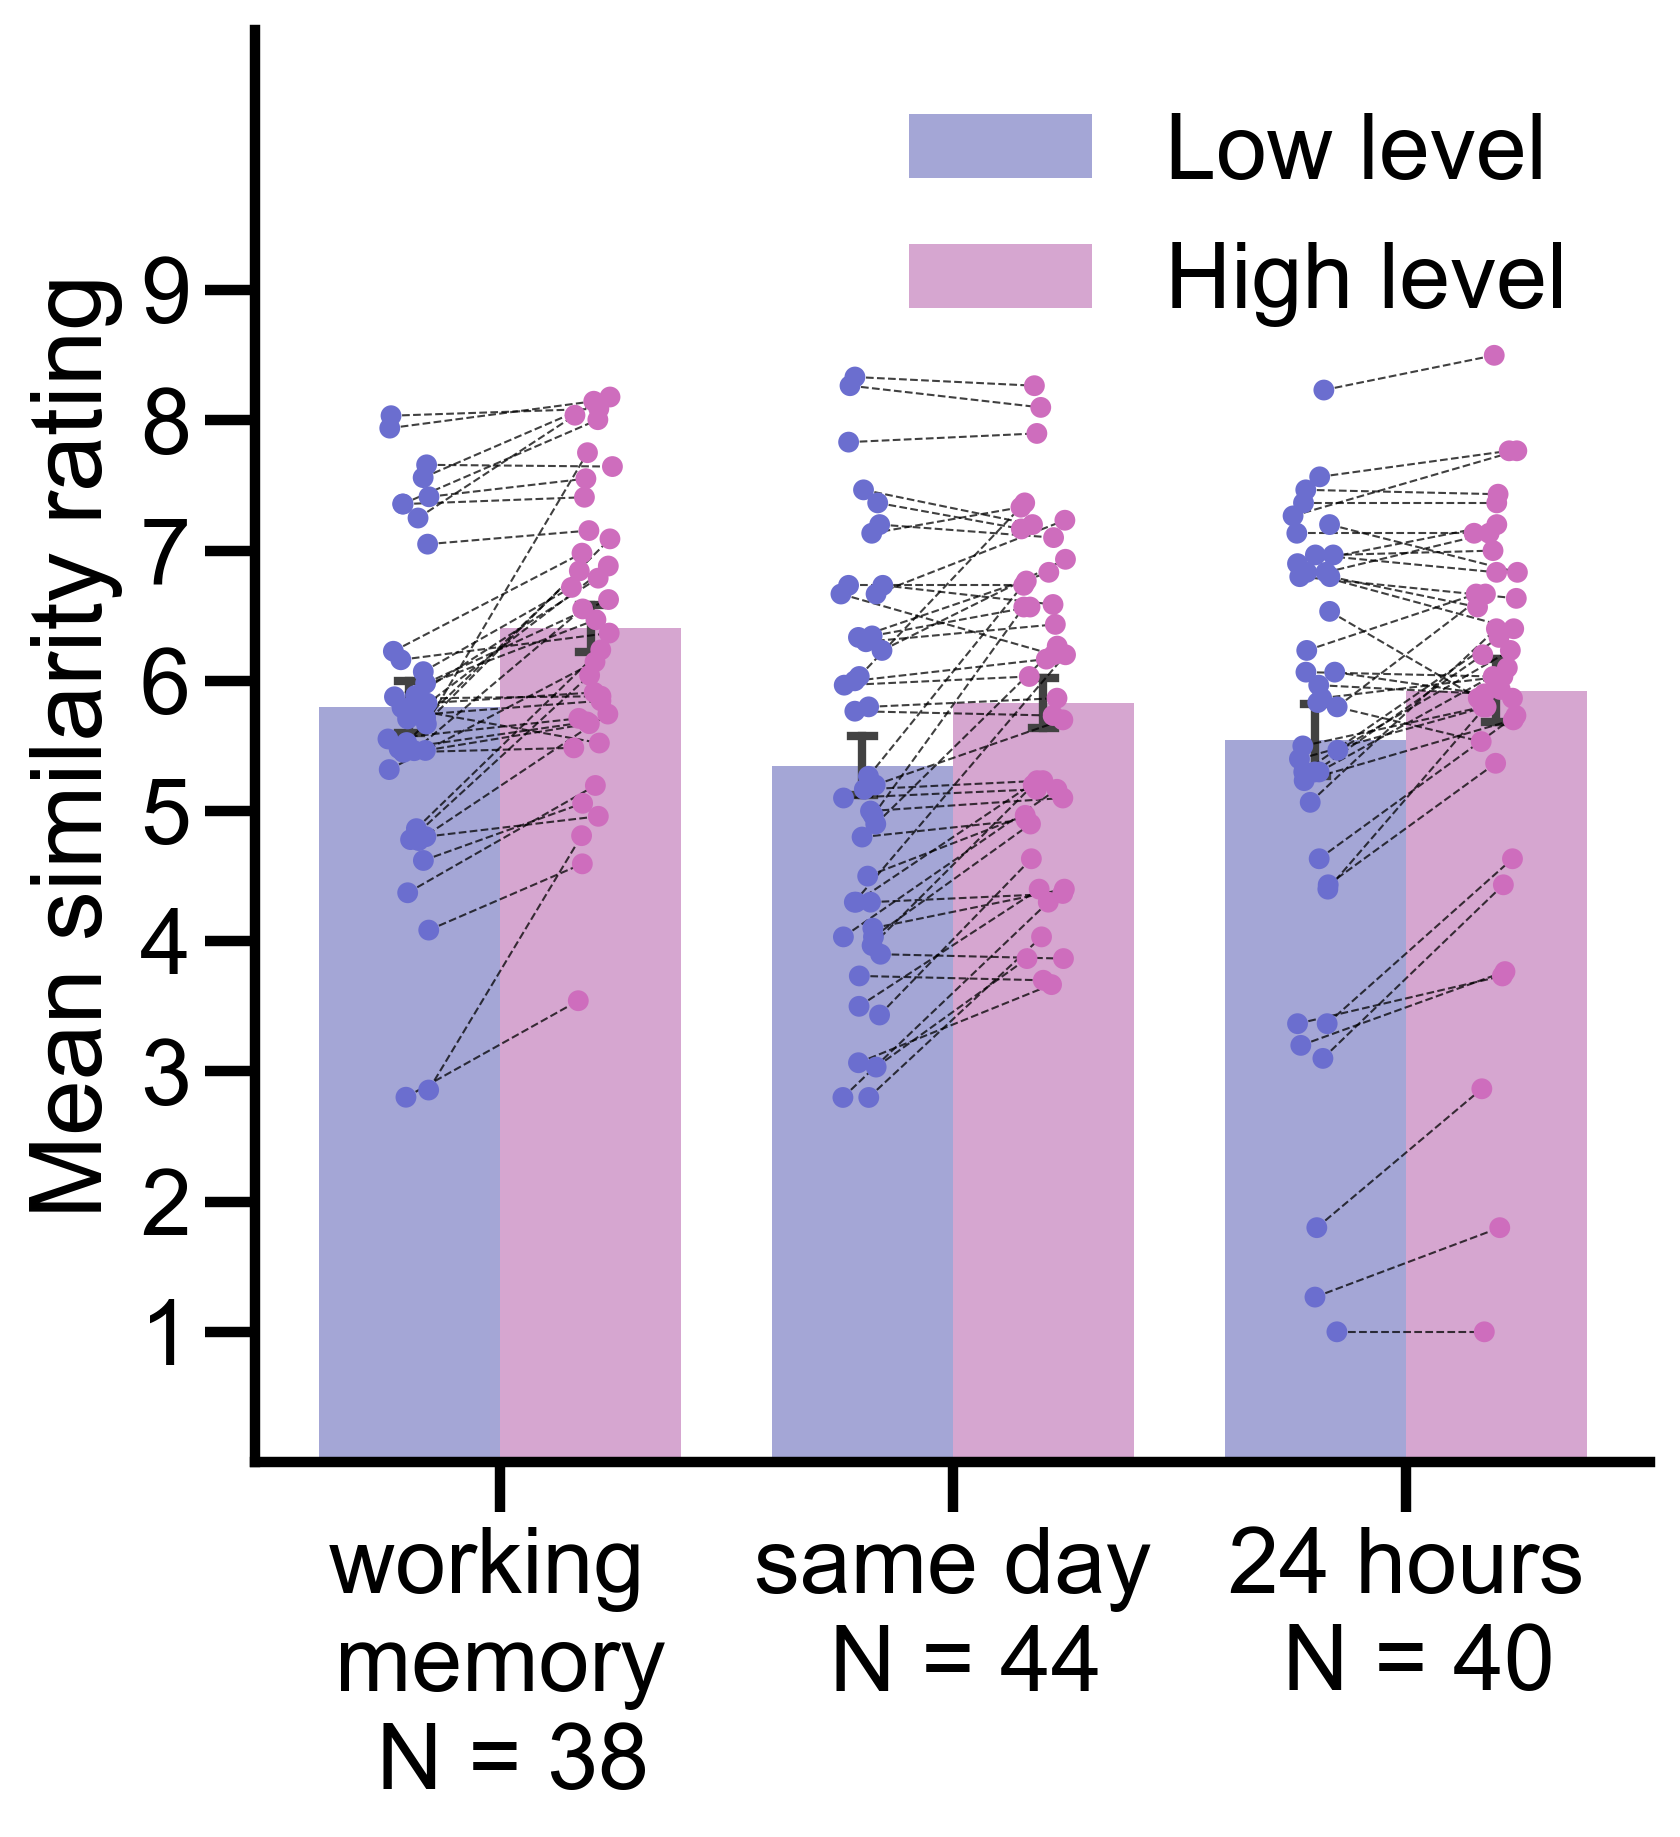

In [120]:
my_order = ['low_level_rating','high_level_rating']

fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(6,6.2),gridspec_kw = {'wspace':0.2, 'hspace':0})
# Hide the right and top spines
axes.spines[['right', 'top']].set_visible(False)
bar = sns.barplot(data =rating_df, x='time_gap',y='value',hue='layer',ax=axes,palette=[sns.color_palette()[3],sns.color_palette()[-1]],hue_order=my_order,order=['working_memory','pilot_same_day','pilot_24_hours'],errorbar='se',capsize=.05,errwidth=2,)
stripplot = sns.stripplot(data =rating_df, x='time_gap',y='value',hue='layer',ax=axes,dodge=True,palette=[sns.color_palette()[2],sns.color_palette()[-2]],hue_order=my_order,order=['working_memory','pilot_same_day','pilot_24_hours'])
# axes[0].set_xticklabels(labels=['pilot_same_day','pilot_24_hours','pilot_one_week'],rotation=30)
add_connecting_lines_to_stripplot(stripplot,axes)
axes.set_xlabel('')
axes.set_xticklabels(labels=[f'working \nmemory\n N = {n_working_memory}',f'same day\n N = {n_same_day}',f'24 hours\n N = {n_24_hours}'])
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[2:],['Low level','High level'],loc='upper right',facecolor='none', framealpha=0)
axes.set_ylabel('Mean similarity rating')
axes.set_ylim([0,11])
axes.set_yticks([1,2,3,4,5,6,7,8,9])

fig.patch.set_alpha(0)
fig.savefig(PATH_TO_EXPERIMENT / ('ratings_per_time_gap_'+qualification_method+'.svg'))
fig.savefig(PATH_TO_EXPERIMENT / ('ratings_per_time_gap_'+qualification_method+'.pdf'))
fig.savefig(PATH_TO_EXPERIMENT / ('ratings_per_time_gap_'+qualification_method+'.png'),transparent=True)

# correlations 

In [121]:
simillarity_df = pd.DataFrame([])
for cat in ['badlands','bridge','golf_course','highway','mountain','playground']:
    filename = f'similarity_between_pairs_VGG{cat}.csv'
   
    cur_similarity_df = pd.read_csv(PATH_TO_LONG_TERM_MEMORY/filename)
    simillarity_df = pd.concat([simillarity_df,cur_similarity_df])


simillarity_df['image1'] = simillarity_df['image1'].str.replace('.pkl','.jpg')
simillarity_df['image2'] = simillarity_df['image2'].str.replace('.pkl','.jpg')


# sort the values in each row
temp1 = simillarity_df[['image1', 'image2']].apply(lambda x: sorted(x)[0], axis=1)
temp2 = simillarity_df[['image1', 'image2']].apply(lambda x: sorted(x)[1], axis=1)
simillarity_df['image1']=temp1
simillarity_df['image2']=temp2


temp1 = df_long_format_all_time_gaps[['image1', 'image2']].apply(lambda x: sorted(x)[0], axis=1)
temp2 = df_long_format_all_time_gaps[['image1', 'image2']].apply(lambda x: sorted(x)[1], axis=1)
df_long_format_all_time_gaps['image1']=temp1
df_long_format_all_time_gaps['image2']=temp2


all_subjects_test_df=pd.merge(simillarity_df, df_long_format_all_time_gaps, on=['image1', 'image2'],how='right')


#all_subjects_test_df = all_subjects_test_df.rename(columns={"test_test_response.corr": "corr", "bar_2.response": "bar_2"})
all_subjects_test_df['mean_sim']=all_subjects_test_df[[col for col in all_subjects_test_df.columns if 'level_' in col]].mean(axis=1)
all_subjects_test_df['mean_sim_0_6']=all_subjects_test_df[['level_0','level_6']].mean(axis=1)

In [122]:
all_subjects_test_df['subject'].nunique()

122

In [132]:
df_24_hours = all_subjects_test_df[all_subjects_test_df['time_gap'] == 'pilot_24_hours']
print(df_24_hours['subject'].nunique())
df_same_day = all_subjects_test_df[all_subjects_test_df['time_gap'] == 'pilot_same_day']
print(df_same_day['subject'].nunique())
df_working_memory = all_subjects_test_df[all_subjects_test_df['time_gap'] == 'working_memory']
print(df_working_memory['subject'].nunique())

df_24_hours_grouped = df_24_hours.groupby(['image1','image2']).aggregate({'rating':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','correct_numeric':'mean'})
df_same_day_grouped = df_same_day.groupby(['image1','image2']).aggregate({'rating':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','correct_numeric':'mean'})
df_working_memory_grouped = df_working_memory.groupby(['image1','image2']).aggregate({'rating':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','correct_numeric':'mean'})

correlations_df_24_hours_grouped=df_24_hours.groupby(['image1','image2']).aggregate({'rating':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','correct_numeric':'mean'})
correlations_df_same_day_grouped=df_same_day.groupby(['image1','image2']).aggregate({'rating':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','correct_numeric':'mean'})
correlations_df_working_memory_grouped = df_working_memory.groupby(['image1','image2']).aggregate({'rating':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','correct_numeric':'mean'})

40
44
38


In [133]:
#we are not sure why this is here .... 
df_24_hours_grouped = df_24_hours_grouped.drop(('bridge_17.jpg','bridge_172.jpg'))
df_same_day_grouped = df_same_day_grouped.drop(('bridge_17.jpg','bridge_172.jpg'))

In [134]:
grouped_df = all_subjects_test_df.groupby(['image1','image2']).aggregate({'rating':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','correct_numeric':'mean'})
grouped_df_corr =all_subjects_test_df.groupby(['image1','image2']).aggregate({'rating':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','correct_numeric':'mean'})

In [135]:
grouped_df = grouped_df.drop(('bridge_17.jpg','bridge_172.jpg'))

rho=-0.109
p=0.238
rho=0.538
p=0.000
rho=-0.385
p=0.000


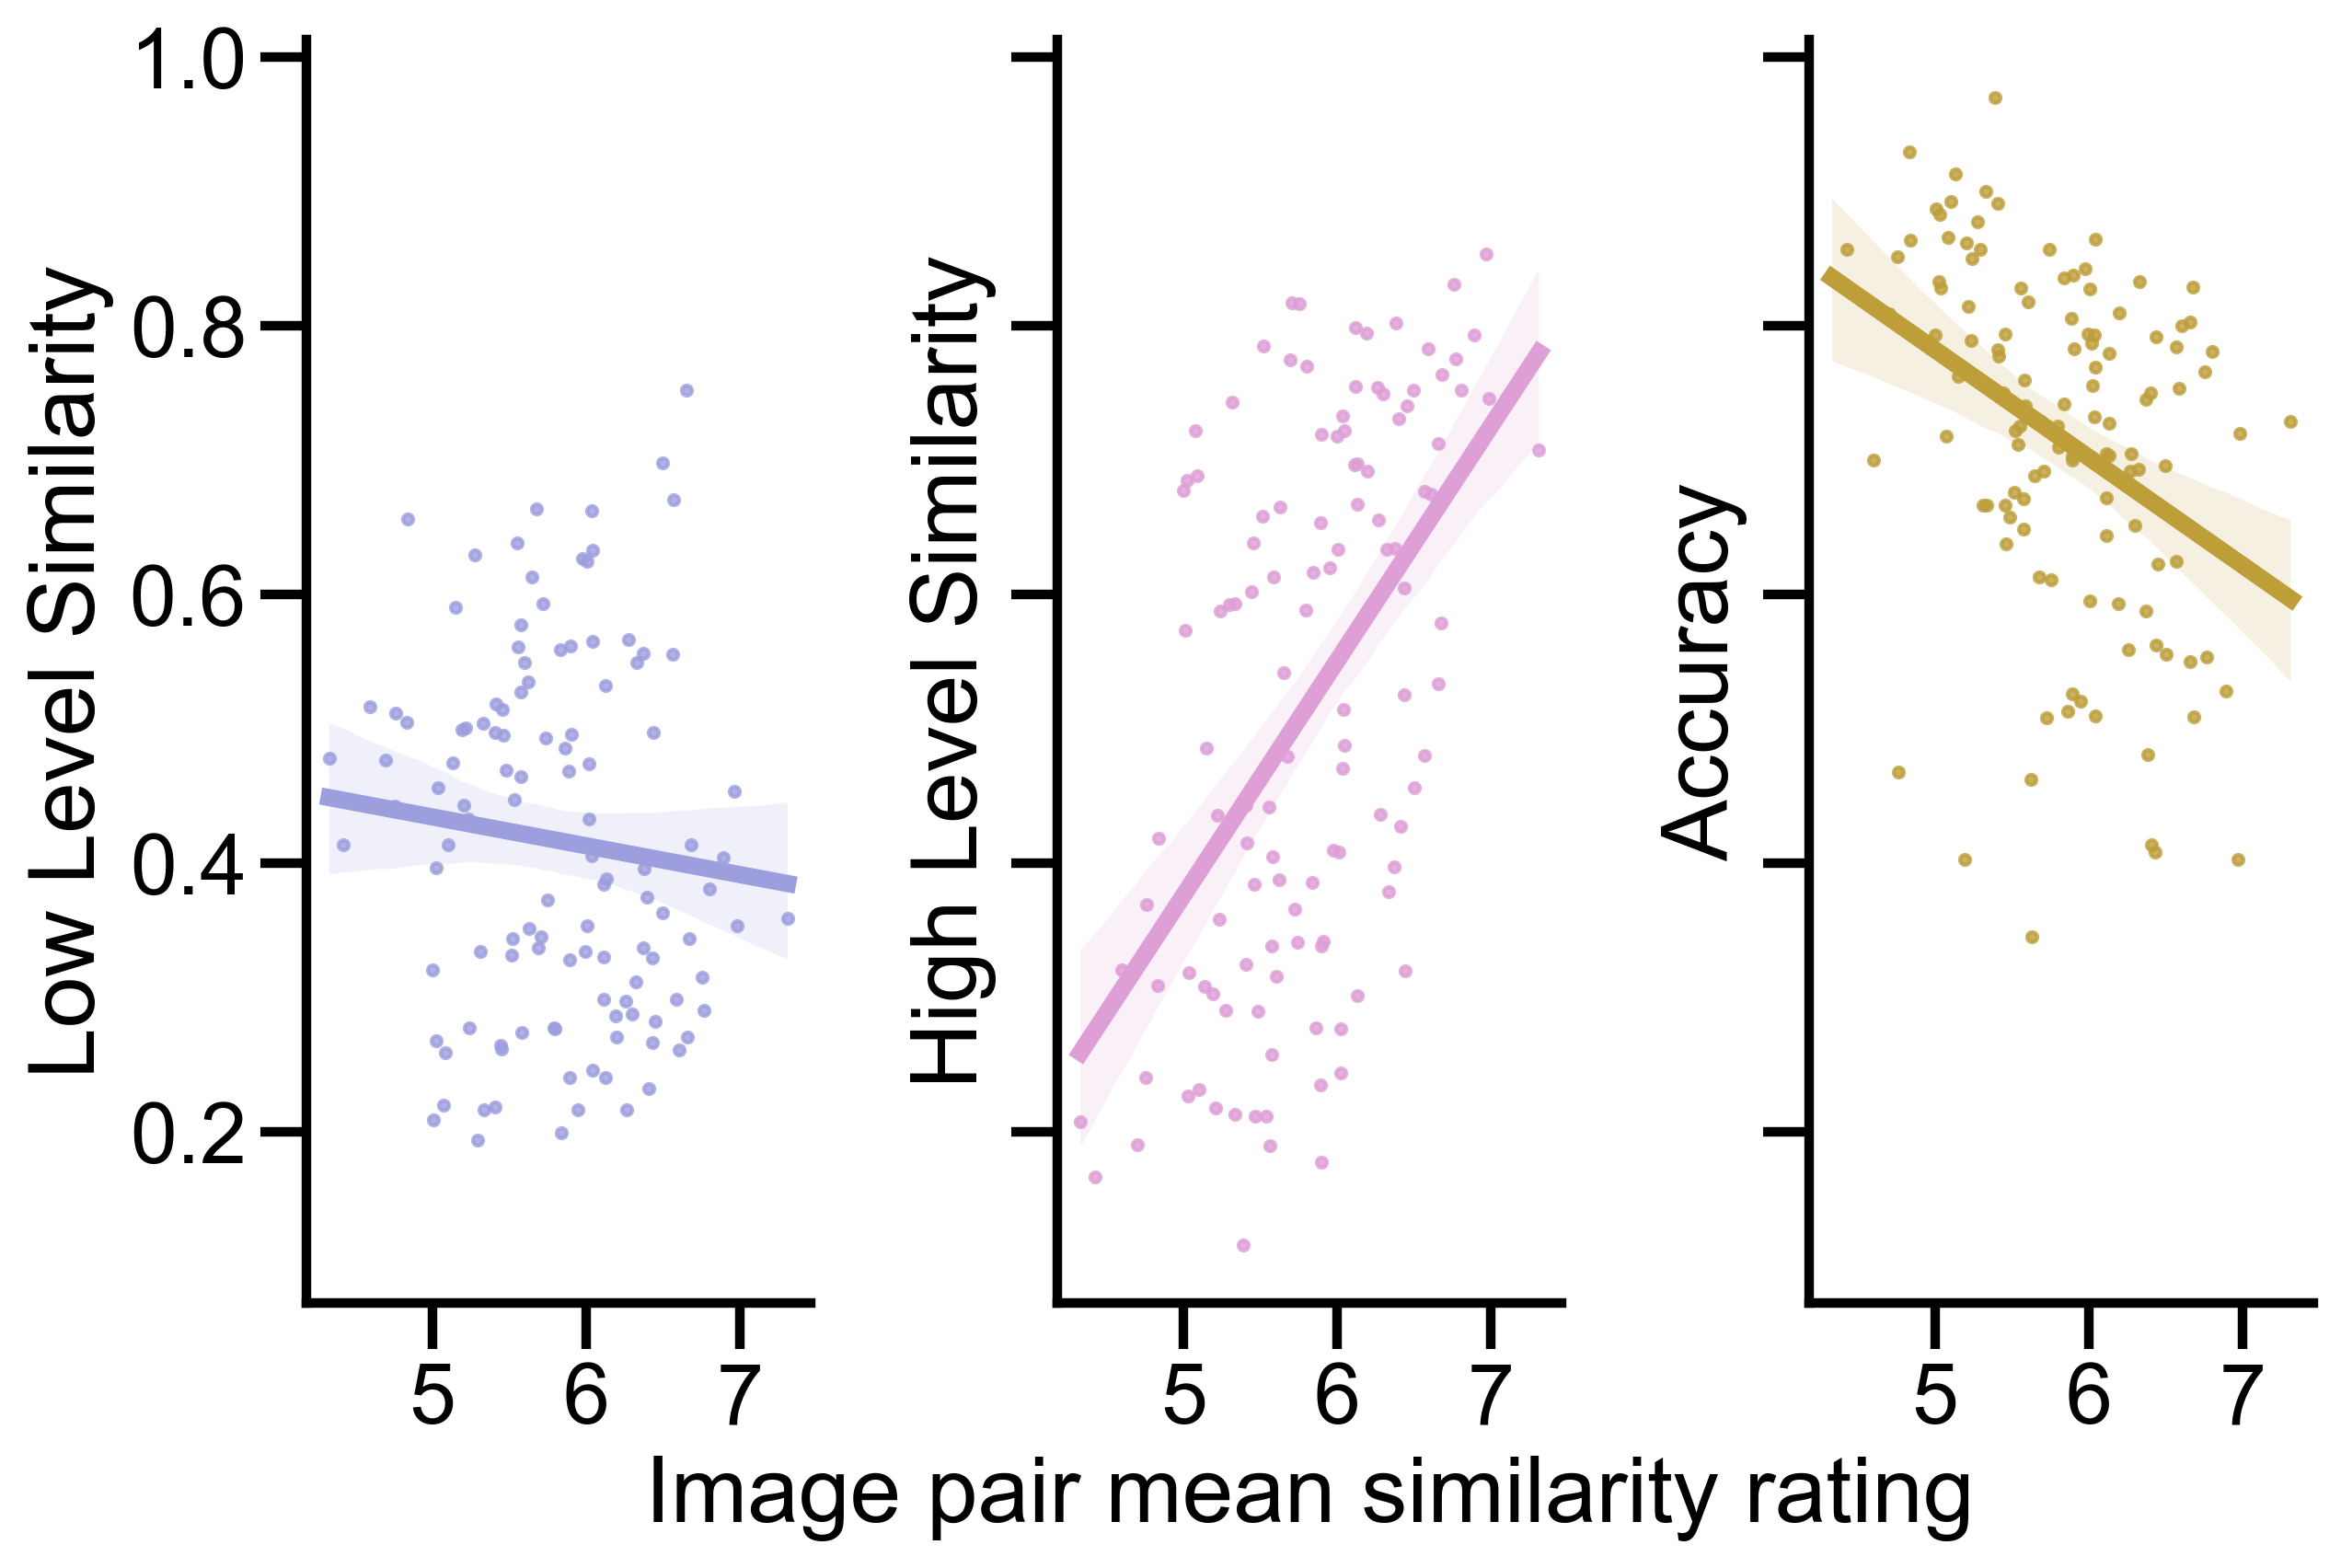

In [136]:
fig,axes=plt.subplots(nrows=1,ncols=3,sharex = True,sharey = True,figsize=(9,6.2))
axes=axes.ravel()
# low level
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=grouped_df_corr['rating'], y=grouped_df_corr['level_0'])
print(f'rho={r_value_24:.3f}\np={p_value_24:.3f}')
sns.regplot(data=grouped_df,x='rating',y='level_0',ax=axes[0],color = sns.color_palette()[3],scatter_kws={'s':7})
axes[0].spines[['right', 'top']].set_visible(False)
axes[0].set_xlabel('')
axes[0].set_ylabel('Low Level Similarity')



# high level
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=grouped_df_corr['rating'], y=grouped_df_corr['level_6'])
print(f'rho={r_value_24:.3f}\np={p_value_24:.3f}')
sns.regplot(data=grouped_df,x='rating',y='level_6',ax=axes[1],color = sns.color_palette()[-1],scatter_kws={'s':7})
axes[1].spines[['right', 'top']].set_visible(False)
axes[1].set_xlabel('Image pair mean similarity rating')
axes[1].set_ylabel('High Level Similarity')



# corr
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=grouped_df_corr['rating'], y=grouped_df_corr['correct_numeric'])
print(f'rho={r_value_24:.3f}\np={p_value_24:.3f}')
sns.regplot(data=grouped_df,x='rating',y='correct_numeric',ax=axes[2],color = sns.color_palette()[9],scatter_kws={'s':7})
axes[2].spines[['right', 'top']].set_visible(False)
axes[2].set_xlabel('')
axes[2].set_ylabel('Accuracy')

fig.tight_layout()

fig.patch.set_alpha(0)

pdf_name = 'correlations_to_similarity_and_accuracy.pdf'
png_name = 'correlations_to_similarity_and_accuracy.png'
plt.savefig(PATH_TO_PROJECT/path.Path('experiment 1/figures and outputs') / pdf_name,format='pdf',bbox_inches='tight')
plt.savefig(PATH_TO_PROJECT/path.Path('experiment 1/figures and outputs') / png_name,format='png',bbox_inches='tight',transparent=True)

rho=-0.052
p=0.576
rho=-0.111
p=0.228
rho=-0.119
p=0.196
rho=0.433
p=0.000
rho=0.490
p=0.000
rho=0.528
p=0.000
rho=-0.246
p=0.007
rho=-0.238
p=0.009
rho=-0.353
p=0.000


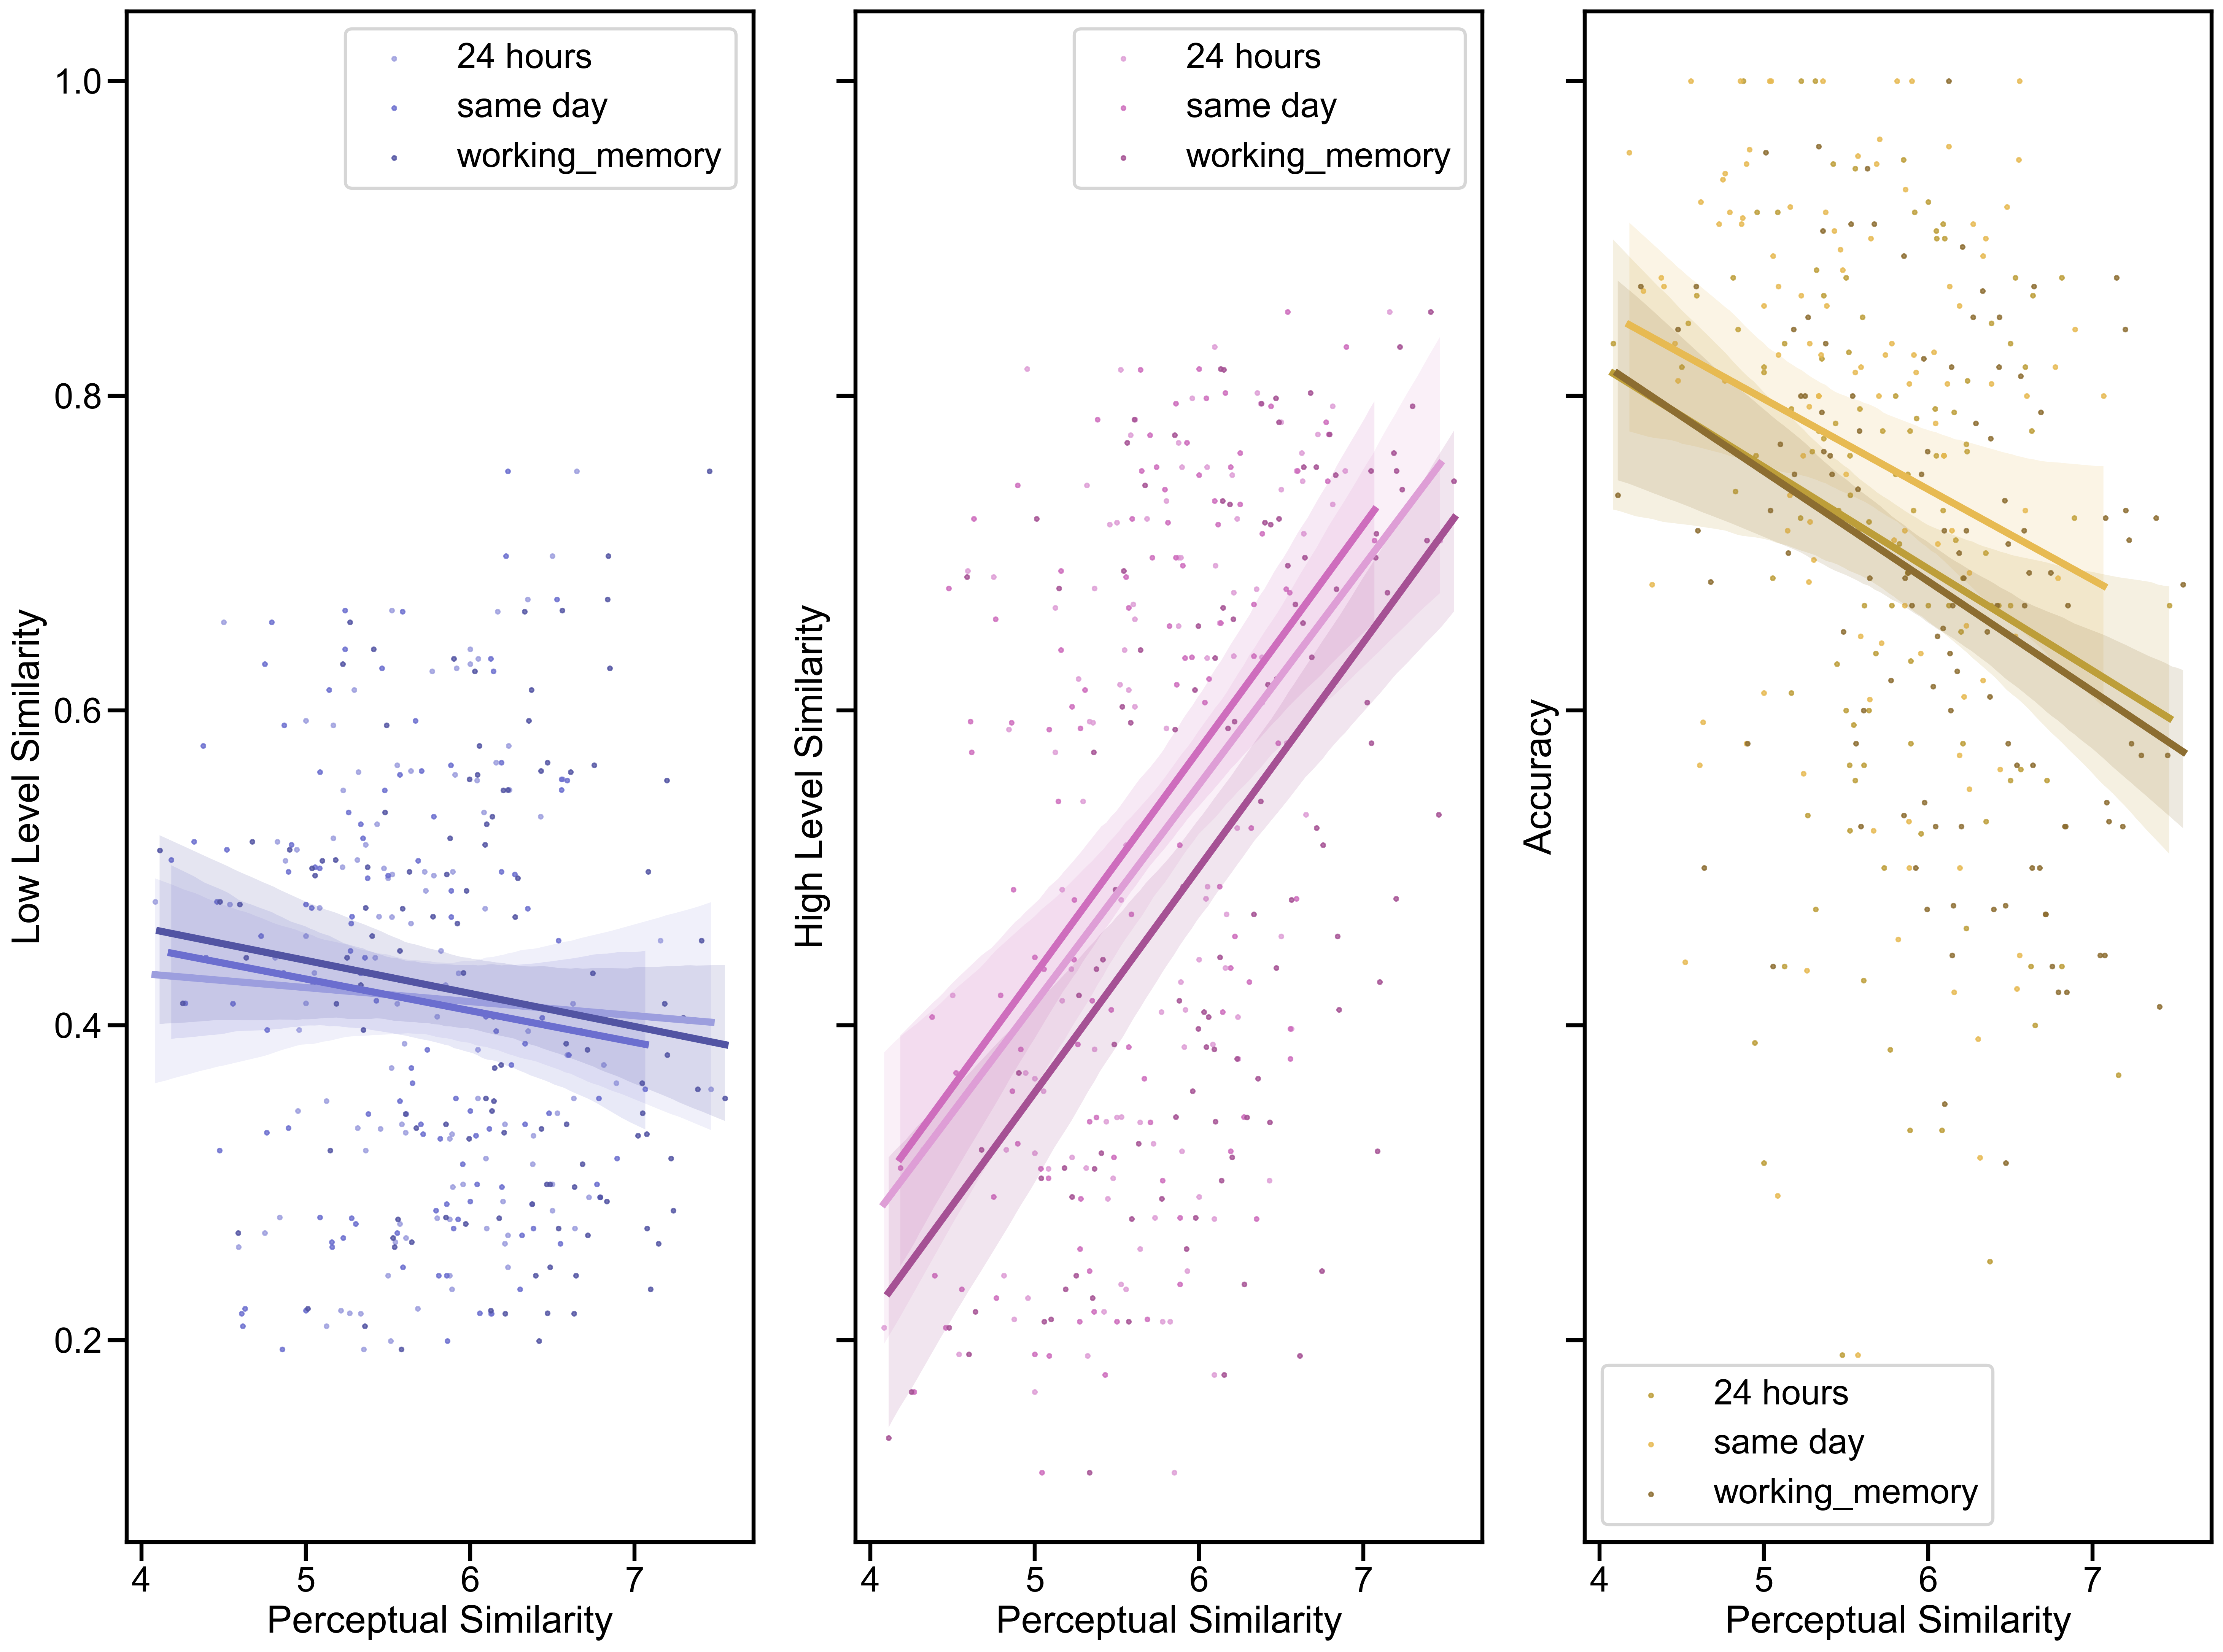

In [137]:
fig,axes=plt.subplots(nrows=1,ncols=3,sharex = True,sharey = True,figsize=(20,15))
axes=axes.ravel()
# low level
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=correlations_df_24_hours_grouped['rating'], y=correlations_df_24_hours_grouped['level_0'])
print(f'rho={r_value_24:.3f}\np={p_value_24:.3f}')
sns.regplot(data=df_24_hours_grouped,x='rating',y='level_0',ax=axes[0],color = sns.color_palette()[3],label = f'24 hours',scatter_kws={'s':7})


slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(x=correlations_df_same_day_grouped['rating'], y=correlations_df_same_day_grouped['level_0'])
print(f'rho={r_value_day:.3f}\np={p_value_day:.3f}')
sns.regplot(data=df_same_day_grouped,x='rating',y='level_0',ax=axes[0],color = sns.color_palette()[2],label = f'same day',scatter_kws={'s':7})

slope_working, intercept_working, r_value_working, p_value_working, std_err_working = stats.linregress(x=correlations_df_working_memory_grouped['rating'], y=correlations_df_working_memory_grouped['level_0'])
print(f'rho={r_value_working:.3f}\np={p_value_working:.3f}')
sns.regplot(data=df_working_memory_grouped,x='rating',y='level_0',ax=axes[0],color = sns.color_palette()[1],label = f'working_memory',scatter_kws={'s':7})


axes[0].set_xlabel('Perceptual Similarity')
axes[0].set_ylabel('Low Level Similarity')
axes[0].legend()


# high level
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=correlations_df_24_hours_grouped['rating'], y=correlations_df_24_hours_grouped['level_6'])
print(f'rho={r_value_24:.3f}\np={p_value_24:.3f}')
sns.regplot(data=df_24_hours_grouped,x='rating',y='level_6',ax=axes[1],color = sns.color_palette()[-1],label = f'24 hours',scatter_kws={'s':7})
#axes[1].set_title(f'perceptual similarity\nand high level similarity')

slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(x=correlations_df_same_day_grouped['rating'], y=correlations_df_same_day_grouped['level_6'])
print(f'rho={r_value_day:.3f}\np={p_value_day:.3f}')
sns.regplot(data=df_same_day_grouped,x='rating',y='level_6',ax=axes[1],color = sns.color_palette()[-2],label = f'same day',scatter_kws={'s':7})

slope_working, intercept_working, r_value_working, p_value_working, std_err_working = stats.linregress(x=correlations_df_working_memory_grouped['rating'], y=correlations_df_working_memory_grouped['level_6'])
print(f'rho={r_value_working:.3f}\np={p_value_working:.3f}')
sns.regplot(data=df_working_memory_grouped,x='rating',y='level_6',ax=axes[1],color = sns.color_palette()[-3],label = f'working_memory',scatter_kws={'s':7})

axes[1].set_xlabel('Perceptual Similarity')
axes[1].set_ylabel('High Level Similarity')
axes[1].legend()



# corr
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=correlations_df_24_hours_grouped['rating'], y=correlations_df_24_hours_grouped['correct_numeric'])
print(f'rho={r_value_24:.3f}\np={p_value_24:.3f}')
sns.regplot(data=df_24_hours_grouped,x='rating',y='correct_numeric',ax=axes[2],color = sns.color_palette()[9],label = f'24 hours',scatter_kws={'s':7})
#axes[3].set_title(f'perceptual similarity\nand accuracy')

slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(x=correlations_df_same_day_grouped['rating'], y=correlations_df_same_day_grouped['correct_numeric'])
print(f'rho={r_value_day:.3f}\np={p_value_day:.3f}')
sns.regplot(data=df_same_day_grouped,x='rating',y='correct_numeric',ax=axes[2],color = sns.color_palette()[10],label = f'same day',scatter_kws={'s':7})

slope_working, intercept_working, r_value_working, p_value_working, std_err_working = stats.linregress(x=correlations_df_working_memory_grouped['rating'], y=correlations_df_working_memory_grouped['correct_numeric'])
print(f'rho={r_value_working:.3f}\np={p_value_working:.3f}')
sns.regplot(data=df_working_memory_grouped,x='rating',y='correct_numeric',ax=axes[2],color = sns.color_palette()[8],label = f'working_memory',scatter_kws={'s':7})

axes[2].set_xlabel('Perceptual Similarity')
axes[2].set_ylabel('Accuracy')
axes[2].legend()
fig.tight_layout()

fig.patch.set_alpha(0)

pdf_name = 'correlations_to_similarity_and_accuracy.pdf'
png_name = 'correlations_to_similarity_and_accuracy.png'
plt.savefig(PATH_TO_PROJECT/path.Path('experiment 1/figures and outputs') / pdf_name,format='pdf',bbox_inches='tight')
plt.savefig(PATH_TO_PROJECT/path.Path('experiment 1/figures and outputs') / png_name,format='png',bbox_inches='tight',transparent=True)

# ANCOVA WITH CNN SIMILARITY 

In [138]:
all_subjects_test_df['subject'].value_counts()

subject
A17K1CHOI773VZ    60
A2D009L2PJ6641    60
A3DLP5ADP74EI0    60
A3H2R42UQR0EPQ    60
A1SN7EOZUW5VP3    60
                  ..
A2M9Q0S025XT75    60
A2INGGZW5GH6RM    60
A2VR9O234UCT9T    60
A28HB7240OFGEW    60
A1ZFUHVIPQOVGK    60
Name: count, Length: 122, dtype: int64

In [139]:
grouped_similairty = all_subjects_test_df.groupby(['subject','distractor_level','time_gap']).aggregate({'mean_sim':'mean'})

grouped_similairty.reset_index(inplace=True)
grouped_similairty.rename({'subject':'worker_ID'},axis=1,inplace=True)

In [140]:
grouped_similairty['worker_ID'].nunique()

122

In [141]:
low_dist = grouped_similairty[grouped_similairty['distractor_level'] == 0.0].set_index('worker_ID')
high_dist = grouped_similairty[grouped_similairty['distractor_level'] == 1.0].set_index('worker_ID')
delta_sim = low_dist['mean_sim'] - high_dist['mean_sim']
df_real_sim = pd.DataFrame(delta_sim)
df_real_sim.rename({'mean_sim':'delta_sim'},axis=1,inplace=True)

In [142]:
df_real_sim

delta_sim
worker_ID                
A10HW8JXM17XLD  -0.003016
A10JXOU89D5RXR  -0.013410
A11246G6L1GMQB  -0.028732
A13WTEQ06V3B6D  -0.017938
A140CEAA0194YY   0.004699
...                   ...
ATPW1MWLW7RBL   -0.021126
AVF2Y89Z0W48N   -0.023866
AW07POT8ABE05   -0.003016
AXO7SR3X4HY5H   -0.002565
AZNIEFUIVB2H0   -0.020325

[122 rows x 1 columns]

In [143]:


#df_real_sim = pd.merge(grouped_similairty,df_real_sim,on='worker_ID')

df_real_sim = pd.merge(delta,df_real_sim,on='worker_ID')

In [145]:
time_gap_df = grouped_similairty[['time_gap','worker_ID']].drop_duplicates()
time_gap_df

time_gap       worker_ID
0    pilot_24_hours  A10HW8JXM17XLD
2    working_memory  A10JXOU89D5RXR
4    working_memory  A11246G6L1GMQB
6    pilot_same_day  A13WTEQ06V3B6D
8    pilot_same_day  A140CEAA0194YY
..              ...             ...
234  pilot_same_day   ATPW1MWLW7RBL
236  working_memory   AVF2Y89Z0W48N
238  pilot_24_hours   AW07POT8ABE05
240  pilot_same_day   AXO7SR3X4HY5H
242  pilot_same_day   AZNIEFUIVB2H0

[122 rows x 2 columns]

In [147]:
delta_sim_df = pd.DataFrame(delta_sim).reset_index().rename({'mean_sim':'delta_sim'},axis=1)
delta_sim_df = pd.merge(delta_sim_df,time_gap_df,how='left',on='worker_ID')
delta_sim_df = pd.merge(delta_sim_df,delta,how='left',on='worker_ID')

In [148]:
delta_sim_df

worker_ID  delta_sim        time_gap      delta
0    A10HW8JXM17XLD  -0.003016  pilot_24_hours  16.666667
1    A10JXOU89D5RXR  -0.013410  working_memory -13.333333
2    A11246G6L1GMQB  -0.028732  working_memory -11.149425
3    A13WTEQ06V3B6D  -0.017938  pilot_same_day  13.333333
4    A140CEAA0194YY   0.004699  pilot_same_day -16.666667
..              ...        ...             ...        ...
117   ATPW1MWLW7RBL  -0.021126  pilot_same_day   6.666667
118   AVF2Y89Z0W48N  -0.023866  working_memory  26.666667
119   AW07POT8ABE05  -0.003016  pilot_24_hours   0.000000
120   AXO7SR3X4HY5H  -0.002565  pilot_same_day  23.333333
121   AZNIEFUIVB2H0  -0.020325  pilot_same_day -10.000000

[122 rows x 4 columns]

In [150]:
df = delta_sim_df[['worker_ID','delta_sim','delta','time_gap']]

In [151]:
# ancova analysis 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Perform mixed-design ANCOVA
formula = 'delta ~ C(time_gap) + delta_sim'
model = ols(formula, data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                   sum_sq     df         F    PR(>F)
C(time_gap)    575.628199    2.0  1.788546  0.171706
delta_sim      139.498693    1.0  0.866878  0.353722
Residual     18988.645932  118.0       NaN       NaN
